## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
from models.custom.modules import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass,shift

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")




%load_ext autoreload
%autoreload 2
device = 'cuda:1'

desired_range = [750,850]
desired_channels = 25

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
%reload_ext autoreload

## Go from nograting cube to grating cube with grad descent


In [122]:
def WienerDeconvolution(final, kernel, lamb = 0.001):
    
    nc = kernel.shape[-1]
    padder = [[0,0]]*(len(kernel.shape) -1) + [[nc//2,nc//2]]
    
    # kernel = np.fft.fftshift(kernel)

    
    kernelpad = np.pad(kernel,padder)
    finalpad = np.pad(final,padder)
    
    kernel_fft = np.fft.fft(kernelpad,axis=-1)
    final_fft = np.fft.fft(finalpad,axis=-1)

    original_fft=(np.conj(kernel_fft)*final_fft)/ (np.square(np.abs(kernel_fft))+ lamb)


    original = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft,axis=-1),axes=-1))

    original = original[...,nc//2:-(nc//2)]

    return original

def create_conv_matrix(template,kernelsize=11):
    '''
    create the convolutional matrix to be used with leastsq for calcpsfkernel. 
    template is the detector image, kernel size is the size of the psf kernel, points is the points of which to calculate 
    '''

    #each row in matrix is multiplied by the psf kernel. the psf kernel acts on only the 11x11 elements around the central element. Therefore
    #each row must have the 11x11 elements around the central one.

    if kernelsize%2==0:
        raise ValueError('kernelsize must be odd')

    border = int(kernelsize//2)
    shape = template.shape
    M = np.zeros((shape[0] * shape[1],kernelsize**2))

    region = np.zeros((shape[0] + kernelsize,shape[1]+kernelsize))
    region[border+1:-border,border+1:-border] = template


    for i in range(shape[0]):
        for j in range(shape[1]):    
            x,y = i+border+1, j+border +1
            
            M[i * shape[1] + j] = region[x-(border):x+(border)+1,y-(border):y+(border)+1].flatten()

    return M

def calc_psf_kernel(result,mask,kernelsize=11):
    '''
    result is the blurred mask we see in camera
    mask is the true mask
    '''

    result = result.flatten() #this is the result (c)
    #we wish to find the psf, h, which is c = h (conv) m

    #first lets decide dimensions of our psf kernel. Lets say 11x11. therefore 121 elements. Now create conv matrix

    M = create_conv_matrix(mask,kernelsize)

    # M += np.random.rand(*M.shape) * 0.000000001


    #now least squares
    psf = np.linalg.inv(M.T@M)@M.T @ result
    
    return psf.reshape((kernelsize,kernelsize))


dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231016_Monochromator/'


In [123]:


mask_nograting_cube = torch.load(dir + 'mask_cube_nograting.pt').to(torch.float32).to(device)

mask_funda_wl = mask_nograting_cube[:,:,100:600,1000:1500]

mask_funda = mask_funda_wl.sum(1).unsqueeze(1)


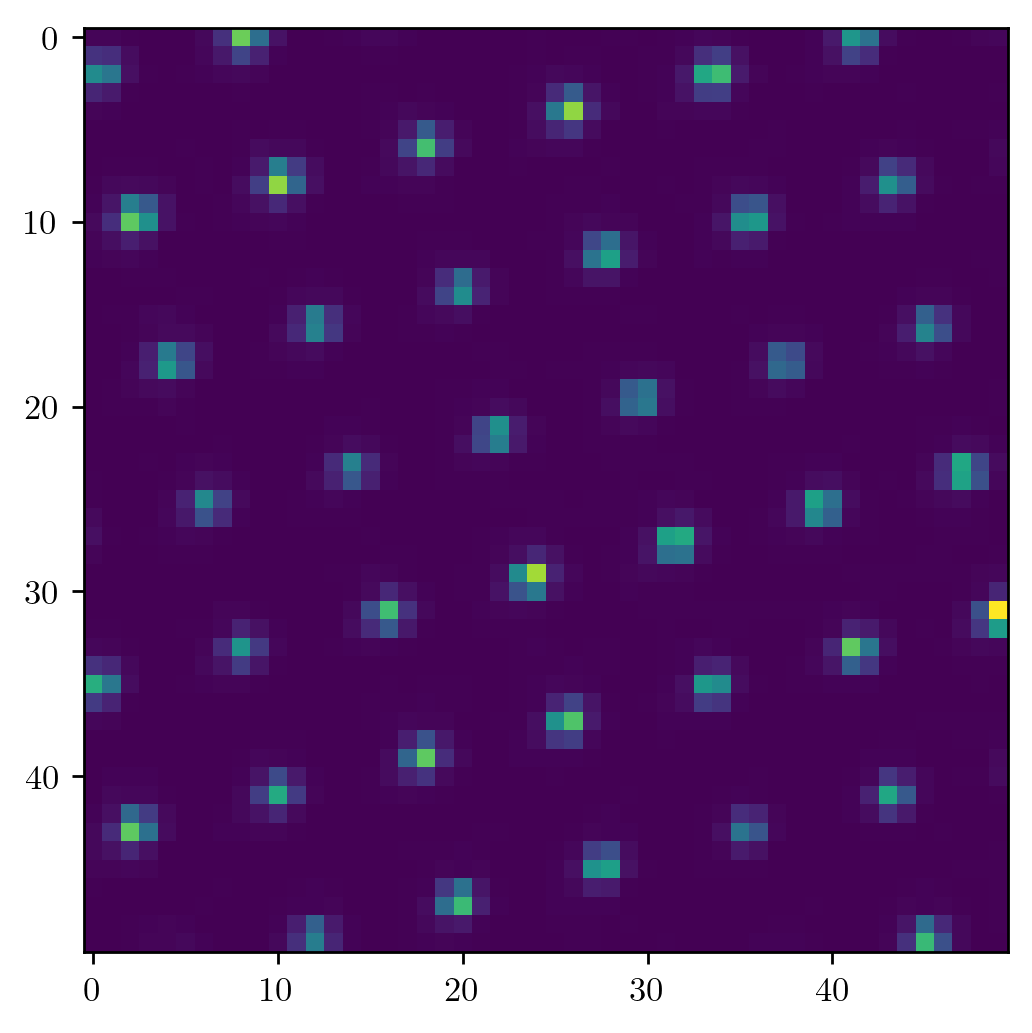

In [124]:
plt.figure(dpi=250)

plt.imshow(mask_nograting_cube[0,11,300:350,1200:1250].cpu())

In [125]:
peaks = peak_local_max(mask_nograting_cube[0,11].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [126]:
peaks

array([[ 304, 1259],
       [ 394, 1364],
       [ 349, 1378],
       ...,
       [ 216, 1080],
       [ 551, 1229],
       [ 334, 1440]])

In [127]:
boxsize = 10

wl = mask_nograting_cube.shape[1]

com_peaks = np.zeros((len(peaks),wl,2),dtype=np.float32)
extracted_peaks = np.zeros((len(peaks), wl, boxsize,boxsize))
simulated_peaks = np.zeros_like(extracted_peaks)
simulated_peaks[:,:,boxsize//2-1:boxsize//2+1,boxsize//2-1:boxsize//2+1] =1

kernelsize = 9

psfs = np.zeros((len(peaks),kernelsize,kernelsize))

for l in range(wl):
    for n,peak in enumerate(peaks):
        print(n/len(peaks),l,end='\r')

        extracted_peaks[n,l] = mask_nograting_cube[0,l,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2].cpu().numpy()
        thresholded = extracted_peaks[n,l].copy()
        thresholded[thresholded<0.05*thresholded.max()] = 0

        com_peaks[n,l] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)



        simulated_peaks[n,l] = shift(simulated_peaks[n,l],com_peaks[n,l]  ,order=1)  
        simulated_peaks[n,l] *=  extracted_peaks[n,l].mean() / simulated_peaks[n,l].mean()

        com_peaks[n,l] += peak


    # psfs[n] = calc_psf_kernel(extracted_peaks[n],simulated_peaks[n],kernelsize=kernelsize)




3.3889850531210186e-07 3.3889850531210186e-07


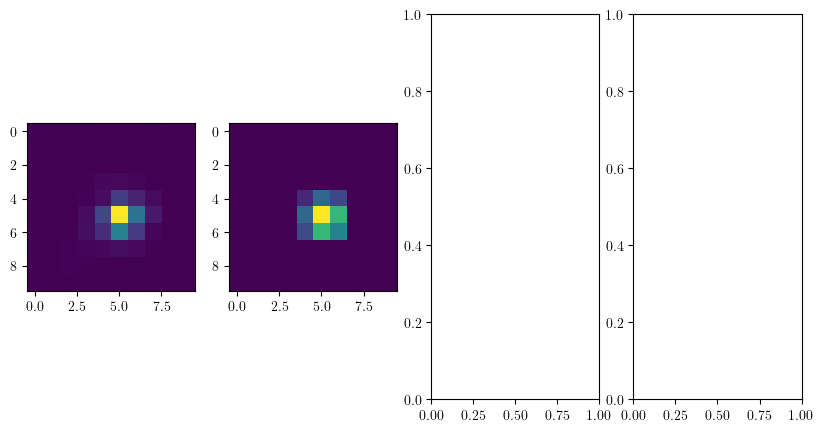

In [128]:
l=11

i = np.random.randint(len(peaks))
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].imshow(extracted_peaks[i,l])
ax[1].imshow(simulated_peaks[i,l])

print(extracted_peaks[i,l].mean(),simulated_peaks[i,l].mean())  


### CoM Training

Lets begin with a map of 2d mask pixels. The model is allowed to rotate them and shift them in order to match the data as best as possible.

In [129]:



peaks = peak_local_max(mask_funda[0,0].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [130]:
peaks.shape

(1962, 2)

In [131]:
boxsize = 8

from scipy.ndimage import center_of_mass,shift
CoMs = np.zeros((len(peaks),2))
for n,peak in enumerate(peaks):
    print(n/len(peaks),end='\r')
    thresholded = mask_funda[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2+1,peak[1]-boxsize//2:peak[1]+boxsize//2+1].cpu().numpy()

    CoMs[n] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)

    CoMs[n] += peak

In [132]:
CoMs.shape

(1962, 2)

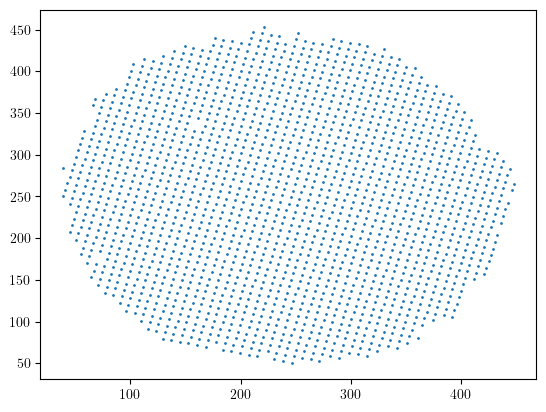

In [133]:
plt.scatter(CoMs[:,1],CoMs[:,0],s=1)    

In [134]:
CoMs = CoMs[(CoMs[:,0] > 200 ) & (CoMs[:,0] < 300 ) & (CoMs[:,1] > 200 ) & (CoMs[:,1] < 300 )]

distances = np.zeros((len(CoMs),len(CoMs)))
for i in range(len(CoMs)):
    for j in range(len(CoMs)):
        distances[i,j] = np.linalg.norm(CoMs[i] - CoMs[j])

In [135]:
CoMs.shape

(155, 2)

In [136]:
distances[distances<5] = np.inf

1.3275001697937343 0.004953099201702548


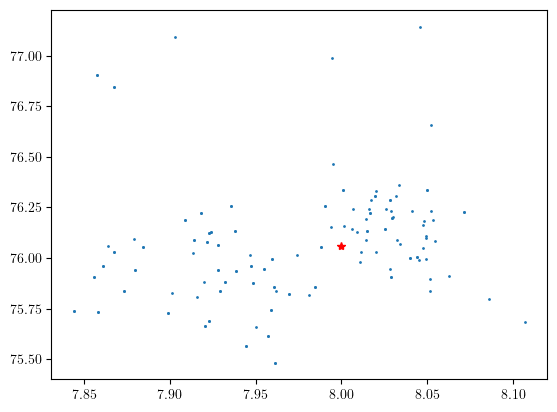

In [137]:
angle = []
distance = []
for i in range(len(CoMs)):
    bla = distances[i].argsort()[:1]

    for j in range(1):

        angle.append(np.arctan2((CoMs[i,0] - CoMs[bla[j],0]) , (CoMs[i,1] - CoMs[bla[j],1])))
        distance.append(distances[i,bla[j]])

# plt.plot(angle,'*')

angle=np.array(angle)

angle[angle>np.pi/2] -= np.pi/2
angle[angle<0] += np.pi/2
angle[angle<0] += np.pi/2

# plt.plot(angle,'*')

plt.scatter(distance,np.rad2deg(angle),s=1)
print(np.mean(angle),np.std(angle))
plt.plot(8,np.rad2deg(np.mean(angle)),'r*')

angle = np.mean(angle)



In [138]:
np.rad2deg(1.3297773343508286)

76.19062895045943

In [139]:

init_guess = torch.zeros((1,1,mask_funda.shape[2],mask_funda.shape[3]))

# peaks = peaks[::3]
# CoMs = CoMs[::3]

peak = peaks[0]

i,j = peak
while i > 0:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < init_guess.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]


    i -= 8

i,j = peak
while i < init_guess.shape[-2]:
    while j>0:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j -= 8
    j = peak[1]
    while j < init_guess.shape[-1]:
        init_guess[:,:,i-1:i+1,j-1:j+1] = 1
        j += 8
    j = peak[1]
    i += 8


# init_guess[:,:,peaks[0,0] - 1:peaks[0,0]+1,peaks[0,1]-1:peaks[0,1]+1] = 1

In [140]:
kernelsize = 9

regions = np.zeros((len(CoMs),2,2))

regions[:,0,0] = (CoMs[:,0] - kernelsize//2).astype(int)
regions[:,0,1] = (CoMs[:,0] + kernelsize//2).astype(int)
regions[:,1,0] = (CoMs[:,1] - kernelsize//2).astype(int)
regions[:,1,1] = (CoMs[:,1] + kernelsize//2).astype(int)

# regions[:,0] = regions[:,0] - 100
# regions[:,1] = regions[:,1] - 1000

regions = torch.tensor(regions,dtype=torch.int)



In [141]:
# loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=2, channels=mask_grating_cube.shape[1])
loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=1, channels=1)

# model = AffineTransformModel(region = regions,rot = 45.,transX=0.,transY=0.,scale = True, no_channels = 1).to(device)
model = AffineTransformModel(region = np.array([[[0,mask_funda.shape[2]],[0,mask_funda.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.06,transY=0.08,scale = False, no_channels = 1, grating=False).to(device)

In [142]:
init_guess = init_guess.to(device)

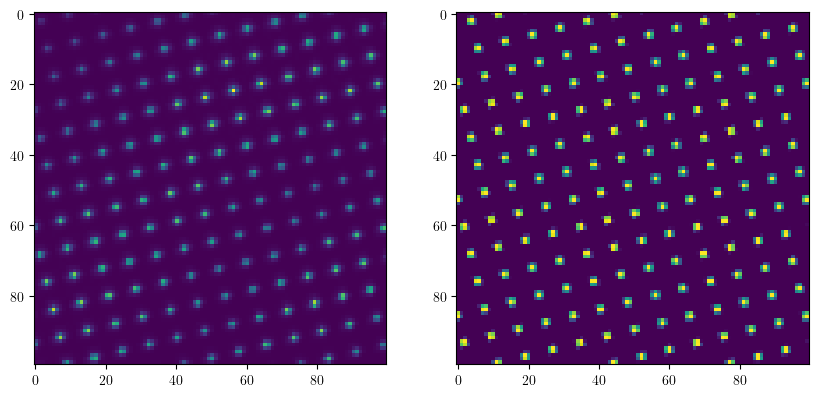

In [143]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(mask_funda.cpu()[0,0,100:200,100:200])

ax[1].imshow(model(init_guess).detach().cpu()[0,0,100:200,100:200])

In [144]:
# init_guess += 0.0001*torch.rand_like(init_guess)

In [145]:
loss_fn(model(init_guess),mask_funda)

tensor(4.5010, device='cuda:1', grad_fn=<DivBackward0>)

In [146]:
init_guess.shape

torch.Size([1, 1, 500, 500])

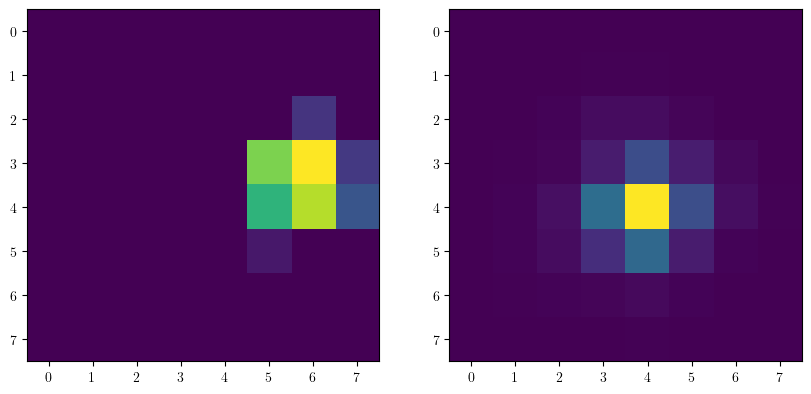

In [147]:
bla = regions[0]
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(model(init_guess)[0,0,bla[0,0]:bla[0,1], bla[1,0]:bla[1,1]].detach().cpu())
ax[1].imshow(mask_funda[0,0,bla[0,0]:bla[0,1], bla[1,0]:bla[1,1]].detach().cpu())


In [148]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

epochs = 300
start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    adjusted = model(init_guess)
    # adjusted = model(mask_funda)
    
    
    # loss =  loss_fn(adjusted, init_guess)
    loss =  loss_fn(adjusted, mask_funda)

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)


In [359]:
theta = model.fill_theta()[0]

grid = nn.functional.affine_grid(theta,mask_funda.shape)

torch.save(grid,'grid.pt')

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


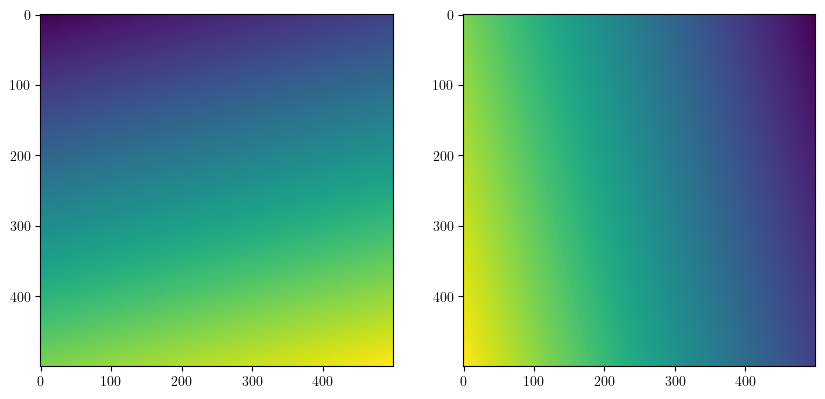

In [357]:
fig,ax = plt.subplots(1,2,figsize=(10,5))


ax[0].imshow(grid[0,...,0].cpu().detach())
ax[1].imshow(grid[0,...,1].cpu().detach())

In [149]:
print(f'original: {-angle};     final: {model.rot_list.data[0].cpu().numpy()},' )

original: -1.3275001697937343;     final: -1.3294858751913934,


In [150]:
model.transX_list, model.transY_list, 

(Parameter containing:
 tensor([0.0514], device='cuda:1', requires_grad=True),
 Parameter containing:
 tensor([0.0793], device='cuda:1', requires_grad=True))

In [151]:
model.rot_list.data[0].cpu().numpy()

array(-1.32948588)

Text(0.5, 1.0, 'affine model result')

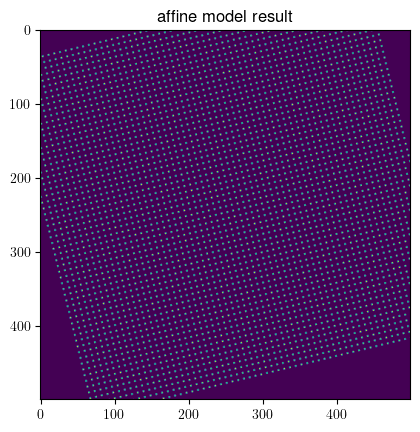

In [152]:
plt.imshow(adjusted[0,0].detach().cpu()); plt.title('affine model result')

Text(0.5, 1.0, 'affine model result')

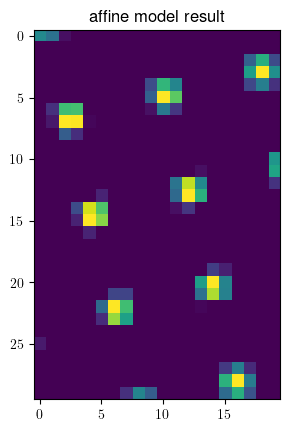

In [154]:
plt.imshow(adjusted[0,0,100:130,150:170].detach().cpu()); plt.title('affine model result')

Text(0.5, 1.0, 'affine model result')

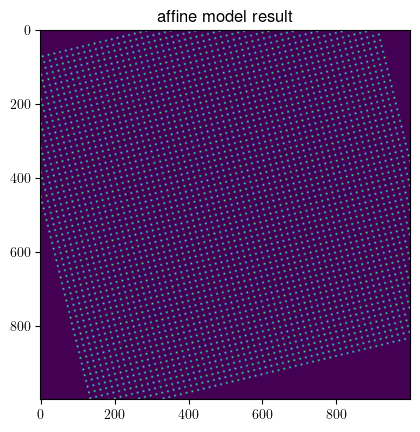

In [189]:
up_factor = 2
init_guess_upsampled = torch.nn.functional.interpolate(init_guess,scale_factor=up_factor,mode='bilinear',align_corners=False) #/ up_factor**2

model.pos = np.array([[[0,init_guess_upsampled.shape[2]],[0,init_guess_upsampled.shape[3]]]])
adjusted_upsampled = model(init_guess_upsampled)
init_guess.sum(), init_guess_upsampled.sum(), adjusted_upsampled.sum()
plt.imshow(adjusted_upsampled[0,0].detach().cpu()); plt.title('affine model result')

In [190]:
adjusted_upsampled.max()

tensor(1., device='cuda:1', grad_fn=<MaxBackward1>)

In [191]:
peaks = peak_local_max(mask_funda[0,0].detach().cpu().numpy(), min_distance=6,threshold_rel=0.03)

In [192]:
wl=25
final_prediction = torch.zeros_like(adjusted).tile(1,wl,1,1)

bord = 4

for l in range(25):
    for peak in peaks:
        synthetic = adjusted[0,0,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()
        true = mask_funda_wl[0,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()
        final_prediction[:,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord] = synthetic   *   ( true.sum() / 4)#synthetic.sum())

In [193]:
bord

4

In [194]:
final_prediction_up = torch.zeros_like(adjusted_upsampled).tile(1,wl,1,1)


for l in range(25):
    for peak in peaks:
        true = mask_funda_wl[0,l,peak[0]-bord:peak[0]+bord,peak[1]-bord:peak[1]+bord].detach().cpu()


        synthetic = adjusted_upsampled[0,0,up_factor*(peak[0]-bord):up_factor*(peak[0]+bord),up_factor*(peak[1]-bord):up_factor*(peak[1]+bord)].detach().cpu()
        final_prediction_up[:,l,up_factor*(peak[0]-bord):up_factor*(peak[0]+bord),up_factor*(peak[1]-bord):up_factor*(peak[1]+bord)] = synthetic   *   ( true.sum() / 4)#synthetic.sum())

In [195]:

down_sampled_ = torch.nn.functional.avg_pool2d(final_prediction_up,up_factor)

final_prediction.mean(), down_sampled_.mean()

(tensor(1.5154e-07, device='cuda:1'), tensor(1.5154e-07, device='cuda:1'))

Text(0.5, 1.0, 'true')

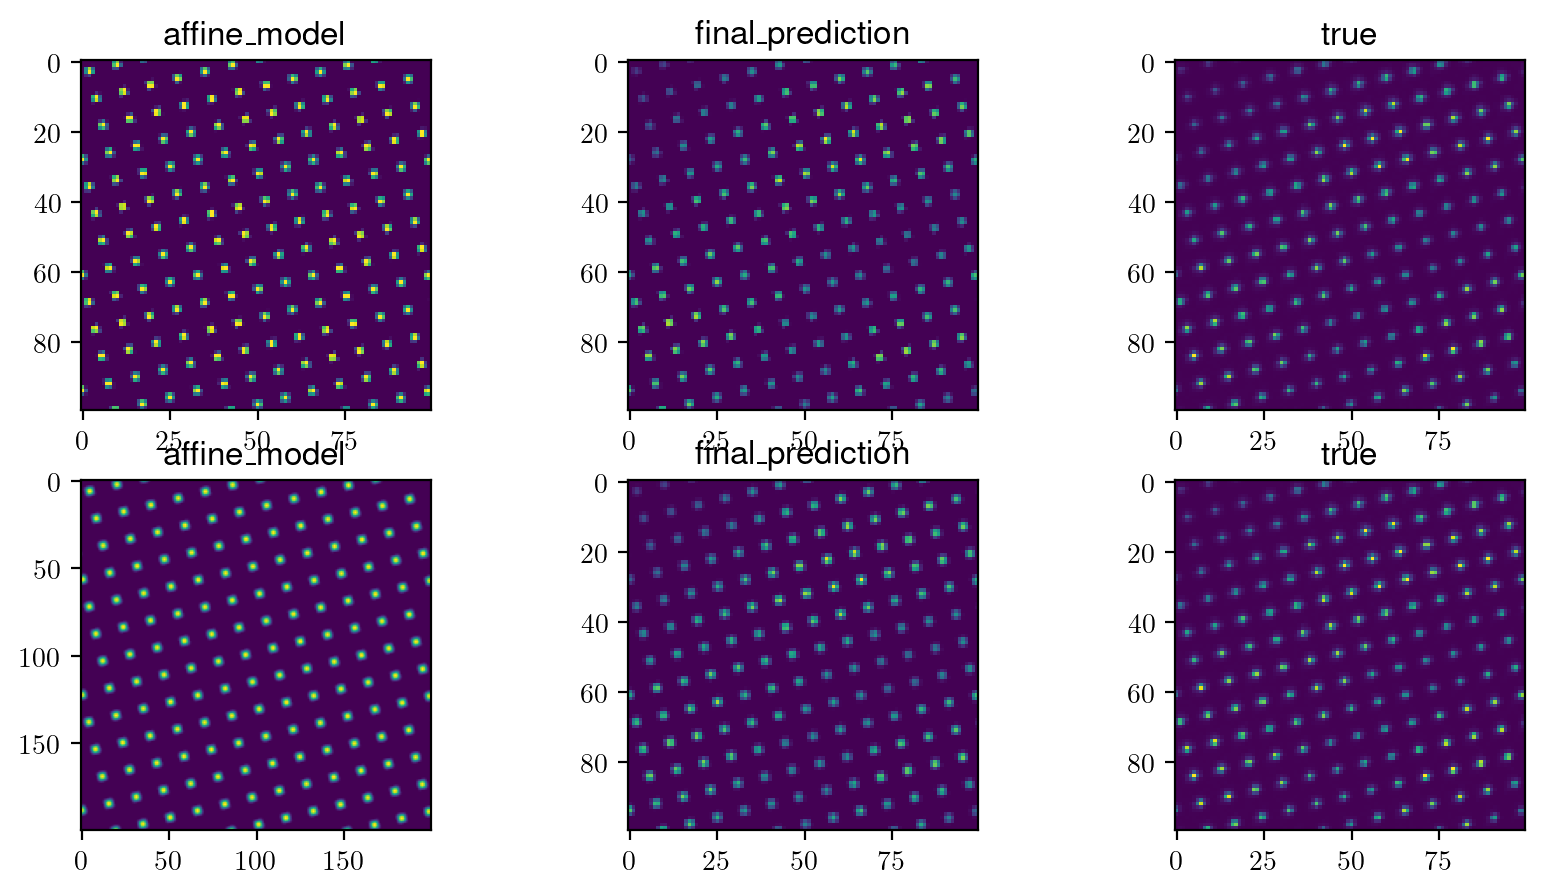

In [197]:
fig,ax = plt.subplots(2,3   ,figsize=(10,5),dpi=200)
ax[0,0].imshow(adjusted[0,0,100:200,100:200].detach().cpu()); ax[0,0].set_title('affine_model')

vmax = final_prediction.cpu()[0,11,100:200,100:200].max()
ax[0,1].imshow(final_prediction.cpu()[0,11,100:200,100:200],vmax=vmax);ax[0,1].set_title('final_prediction')
ax[0,2].imshow(mask_funda_wl[0,11,100:200,100:200].detach().cpu(),vmax=vmax);ax[0,2].set_title('true')

ax[1,0].imshow(adjusted_upsampled[0,0,200:400,200:400].detach().cpu()); ax[1,0].set_title('affine_model')
down_sampled_ = torch.nn.functional.avg_pool2d(final_prediction_up,up_factor)

vmax = down_sampled_.cpu()[0,11,100:200,100:200].max()
ax[1,1].imshow(down_sampled_.cpu()[0,11,100:200,100:200],vmax=vmax);ax[1,1].set_title('final_prediction')
ax[1,2].imshow(mask_funda_wl[0,11,100:200,100:200].detach().cpu(),vmax=vmax);ax[1,2].set_title('true')

In [198]:
mask_funda_wl[0,11,100:200,100:200].detach().cpu().max(),vmax

(tensor(1.1230e-05), tensor(8.9210e-06))

Text(0.5, 1.0, 'true')

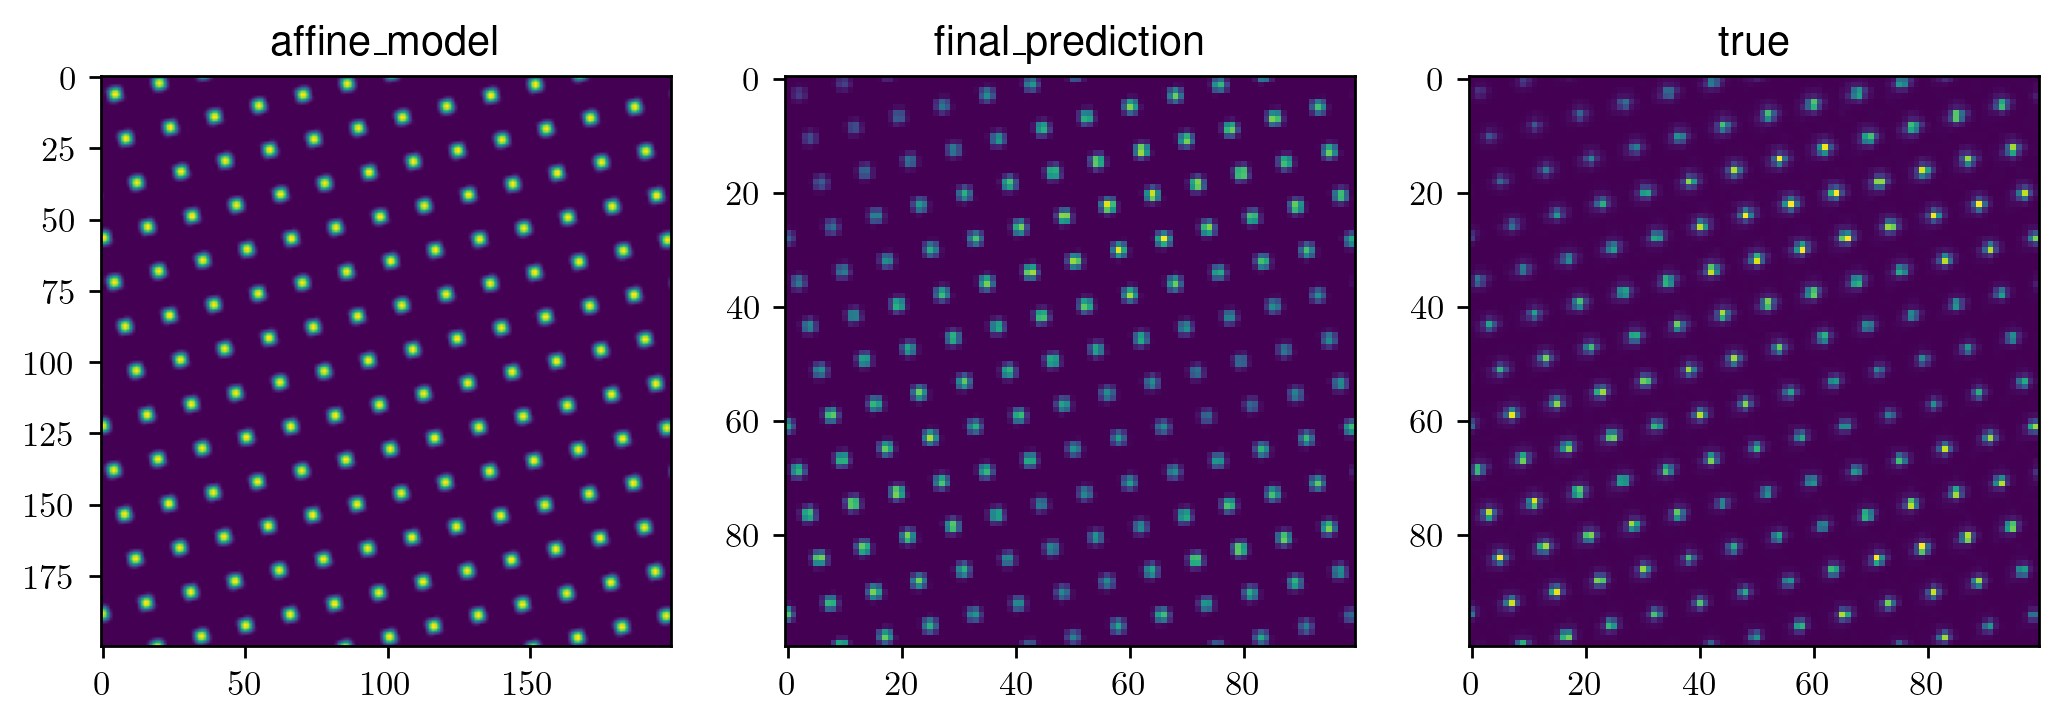

In [199]:
fig,ax = plt.subplots(1,3   ,figsize=(10,5),dpi=250)
ax[0].imshow(adjusted_upsampled[0,0,200:400,200:400].detach().cpu()); ax[0].set_title('affine_model')


down_sampled_ = torch.nn.functional.avg_pool2d(final_prediction_up,up_factor)

vmax = down_sampled_.cpu()[0,11,100:200,100:200].max()
ax[1].imshow(down_sampled_.cpu()[0,11,100:200,100:200],vmax=vmax);ax[1].set_title('final_prediction')
ax[2].imshow(mask_funda_wl[0,11,100:200,100:200].detach().cpu(),vmax=vmax);ax[2].set_title('true')

Text(0.5, 1.0, 'final_prediction')

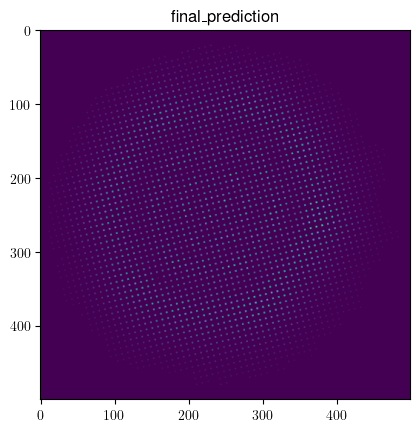

In [200]:
plt.imshow(final_prediction[0,11].detach().cpu()); plt.title('final_prediction')

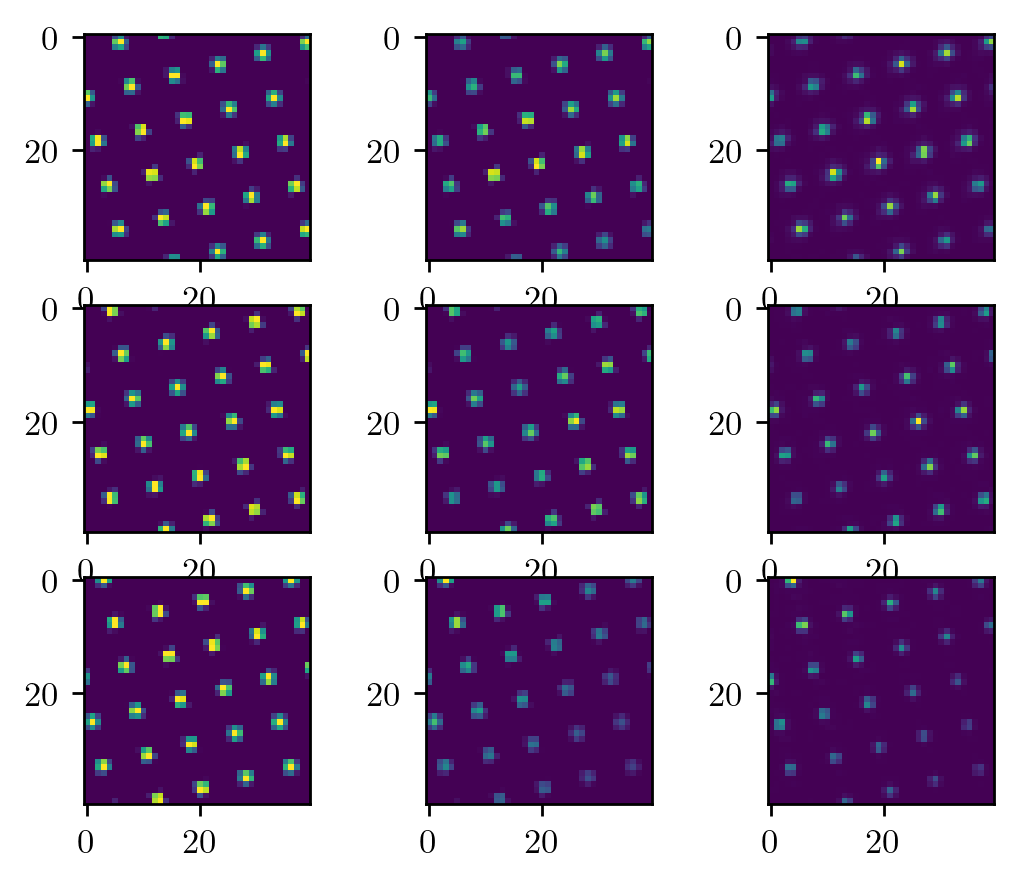

In [201]:
fig,ax = plt.subplots(3,3   ,figsize=(5,4),dpi=250)
ax[0,0].imshow(adjusted[0,0,160:200,160:200].detach().cpu())
ax[0,1].imshow(final_prediction.cpu()[0,10,160:200,160:200])
ax[0,2].imshow(mask_funda_wl[0,10,160:200,160:200].detach().cpu())
ax[1,0].imshow(adjusted[0,0,260:300,260:300].detach().cpu())
ax[1,1].imshow(final_prediction.cpu()[0,10,260:300,260:300])
ax[1,2].imshow(mask_funda_wl[0,10,260:300,260:300].detach().cpu())
ax[2,0].imshow(adjusted[0,0,360:400,360:400].detach().cpu())
ax[2,1].imshow(final_prediction.cpu()[0,10,360:400,360:400])
ax[2,2].imshow(mask_funda_wl[0,10,360:400,360:400].detach().cpu())

In [202]:
mask_funda_wl.mean(), mask_funda.mean()

(tensor(1.5566e-07, device='cuda:1'), tensor(3.8916e-06, device='cuda:1'))

In [203]:
final_prediction *= mask_funda_wl.mean() / final_prediction.mean() 
final_prediction_up *= mask_funda_wl.mean() / final_prediction_up.mean()

In [204]:
groundtruth = torch.zeros_like(mask_nograting_cube).to('cpu')
groundtruth[:,:,100:600,1000:1500] = final_prediction
torch.save(groundtruth,dir + 'groundtruth.pt')
torch.save(final_prediction_up,dir + 'final_prediction_up.pt')

################

In [205]:

final_prediction = torch.load(dir + 'groundtruth.pt').to(device)[...,100:600,1000:1500]
final_prediction_up = torch.load(dir + 'final_prediction_up.pt').to(device)

# normalized_meas = torch.load(dir + 'norm_meas.pt').to(device)
# final_prediction = torch.load(dir + 'norm_truth.pt').to(device)

Normalize each spot?

In [206]:
wl = 11

peaks = peak_local_max(final_prediction[0,wl].detach().cpu().numpy(), min_distance=6,threshold_rel=0.03)

In [283]:

x = torch.zeros_like(final_prediction[:,wl:wl+1]).to(device)
y = torch.zeros_like(final_prediction[:,wl:wl+1]).to(device)

bord = 4

for peak in peaks:
    synthetic = final_prediction[0,wl,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1].detach().cpu()
    true = mask_funda_wl[0,wl,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1].detach().cpu()

    x[:,0,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1] = synthetic   #*   (4/synthetic.sum())#synthetic.sum())
    y[:,0,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1] = true   #*   (4/true.sum())#synthetic.sum())


# x = torch.zeros_like(final_prediction_up[:,wl:wl+1]).to(device)
# y = torch.zeros_like(final_prediction[:,wl:wl+1]).to(device)

# bord = 4

# for peak in peaks:
#     synthetic = final_prediction_up[0,wl,2*(peak[0]-bord):2*(peak[0]+bord+1),2*(peak[1]-bord):2*(peak[1]+bord+1)].detach().cpu()
#     true = mask_funda_wl[0,wl,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1].detach().cpu()

#     x[:,0,2*(peak[0]-bord):2*(peak[0]+bord+1),2*(peak[1]-bord):2*(peak[1]+bord+1)] = synthetic   #*   (4/synthetic.sum())#synthetic.sum())
#     y[:,0,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1] = true   #*   (4/true.sum())#synthetic.sum())



In [284]:

y = y / x.mean()
x = x / x.mean()

Text(0.5, 1.0, 'final_prediction')

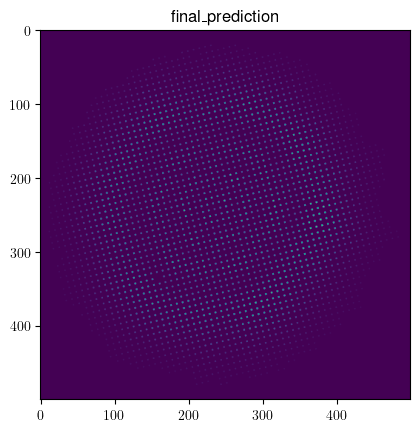

In [285]:
plt.imshow(x[0,0].detach().cpu()); plt.title('final_prediction')

In [286]:
x.mean(),y.mean(), x.max(), y.max()

(tensor(1., device='cuda:1'),
 tensor(0.9733, device='cuda:1'),
 tensor(66.7043, device='cuda:1'),
 tensor(71.5877, device='cuda:1'))

In [287]:
peaks[0]

array([265, 381])

/tmp/user/25186/ipykernel_2104715/4069947464.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[0,0].imshow(x[0,0,2*(peak[0]-4):2*(peak[0]+5),2*(peak[1]-4):2*(peak[1]+5)].detach().cpu());
/tmp/user/25186/ipykernel_2104715/4069947464.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0,0].imshow(x[0,0,2*(peak[0]-4):2*(peak[0]+5),2*(peak[1]-4):2*(peak[1]+5)].detach().cpu());
/tmp/user/25186/ipykernel_2104715/4069947464.py:9: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1,0].imshow(x[0,0,2*(peak[0]-4):2*(peak[0]+5),2*(peak[1]-4):2*(peak[1]+5)].detach().cpu());


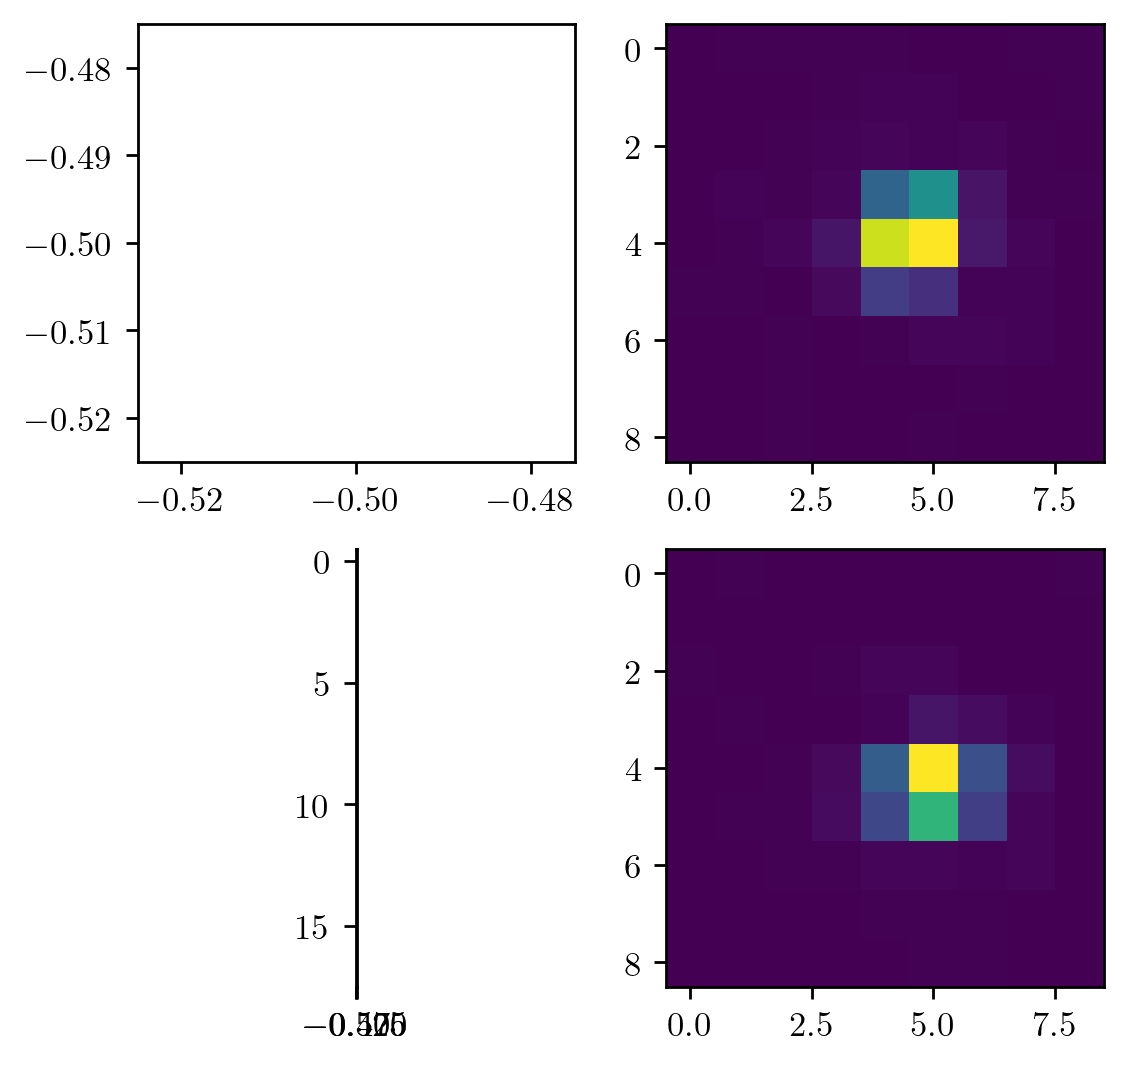

In [288]:
peak = peaks[0]
fig,ax = plt.subplots(2,2,figsize=(5,5),dpi=250)
# ax[0,0].imshow(x[0,0,peak[0]-4:peak[0]+5,peak[1]-4:peak[1]+5].detach().cpu());
ax[0,0].imshow(x[0,0,2*(peak[0]-4):2*(peak[0]+5),2*(peak[1]-4):2*(peak[1]+5)].detach().cpu());
ax[0,1].imshow(y[0,0,peak[0]-4:peak[0]+5,peak[1]-4:peak[1]+5].detach().cpu());
peak = peaks[10]

# ax[1,0].imshow(x[0,0,peak[0]-4:peak[0]+5,peak[1]-4:peak[1]+5].detach().cpu());
ax[1,0].imshow(x[0,0,2*(peak[0]-4):2*(peak[0]+5),2*(peak[1]-4):2*(peak[1]+5)].detach().cpu());
ax[1,1].imshow(y[0,0,peak[0]-4:peak[0]+5,peak[1]-4:peak[1]+5].detach().cpu());


Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{f}$')

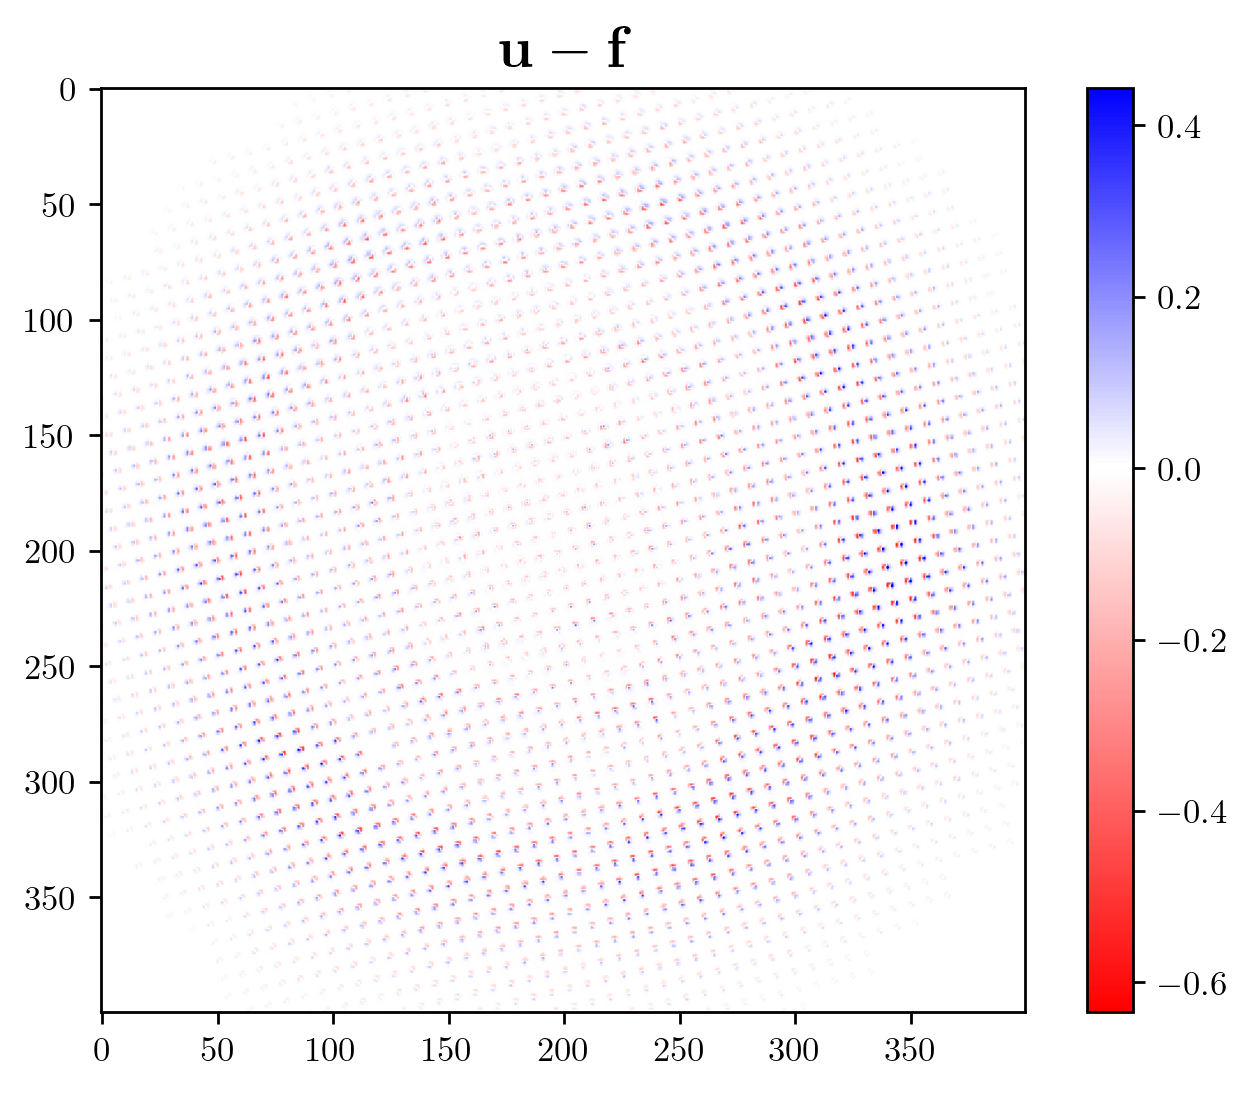

In [290]:
from scipy.ndimage import gaussian_filter


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.figure(dpi=250)
import matplotlib


red = np.array([1,0,0])
white = np.array([1,1,1])
blue = np.array([0,0,1])

colors = []
for i in np.linspace(0,1,100):
    colors.append(  (1-i) * red + (i) * white)             
for i in np.linspace(0,1,70):
    colors.append(  (1-i) * white + (i) * blue)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)


truth = x[0,0] / y[0,0].max()
measurement = y[0,0] / y[0,0].max()

# truth = nn.functional.avg_pool2d(truth.unsqueeze(0).unsqueeze(0),2,2).squeeze()

conv_kernel = torch.zeros((1,1,3,3)).to(device)
conv_kernel[:,:,1,1] = 1
# conv_kernel[:,:,0,1] = 0.1683
# conv_kernel[:,:,0,2] = .3851

conv_kernel = conv_kernel / conv_kernel.sum()


truth = nn.functional.conv2d(truth[50:450,40:440].unsqueeze(0).unsqueeze(0),conv_kernel,padding=1).squeeze()
measurement = measurement[50:450,40:440]

diff = ((measurement - truth)).detach().cpu().numpy()

vmax_diff = np.abs(diff).max()



plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{f}$',fontsize=17)


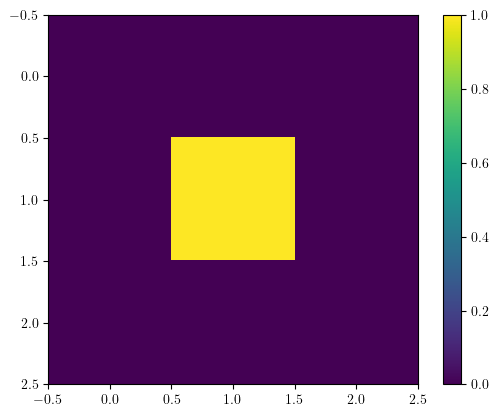

In [291]:
plt.imshow(torch.flip(conv_kernel[0,0].cpu(),(0,1))); plt.colorbar()

In [293]:
CG_channels = 9
kernelsize = 3



downsample = [2,2]

# initialiser = torch.ones((1,CG_channels,mask_funda.shape[2]//downsample[0],mask_funda.shape[3]//downsample[1]))
# initialiser = initialiser / CG_channels

# initialiser = torch.rand((1,2,mask_funda.shape[2]//downsample[0],mask_funda.shape[3]//downsample[1]))
# # initialiser = initialiser
# initialiser[:,0] *= 2*np.pi

x_pos = torch.linspace(-1,1,x.shape[2]//downsample[0])
y_pos = torch.linspace(-1,1,x.shape[3]//downsample[1])
xx,yy = torch.meshgrid(x_pos,y_pos)
angles = torch.atan2(yy,xx).unsqueeze(0).unsqueeze(0)
angles += 1.5*np.pi
angles = angles % (2*np.pi)
angles = -angles + 2*np.pi
# angles = -angles + 2*np.pi
# distances = torch.ones_like(angles) * 0.5#torch.sqrt(xx**2 + yy**2).unsqueeze(0).unsqueeze(0)
distances = torch.sqrt(xx**2 + yy**2).unsqueeze(0).unsqueeze(0)
# distances = distances / distances.max()


x_disp = torch.cos(angles) * distances
y_disp = torch.sin(angles) * distances

initialiser = torch.cat((x_disp,y_disp),dim=1)



# CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=True, three_d=False,downsample = downsample).to(device) 
CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = x.shape[2:],CG_type='radial',initialiser = initialiser, locally_connected=True, three_d=False,downsample = downsample).to(device) 

CG_conv.CG.conv.weight.data = torch.ones_like(CG_conv.CG.conv.weight.data)
CG_conv.CG.conv.bias.data = torch.zeros_like(CG_conv.CG.conv.bias.data)
CG_conv.CG.conv.requires_grad_(False)




Conv2d(9, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)

In [294]:
# angles = initialiser[:,0:1]
# distances = initialiser[:,1:2]

# map = create_bilinear_coeff_map_cart(angles,distances,)
# map.shape

# fig,ax = plt.subplots(1,3)
# ax[0].imshow(angles[0,0].cpu())
# ax[1].imshow(torch.sin(angles[0,0].cpu()))
# ax[2].imshow(torch.cos(angles[0,0].cpu()))

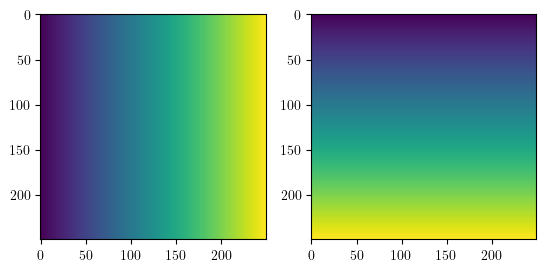

In [296]:
map = create_bilinear_coeff_map_cart_3x3(x_disp,y_disp)
fig,ax = plt.subplots(1,2)
ax[0].imshow(x_disp[0,0].cpu())
ax[1].imshow(y_disp[0,0].cpu())

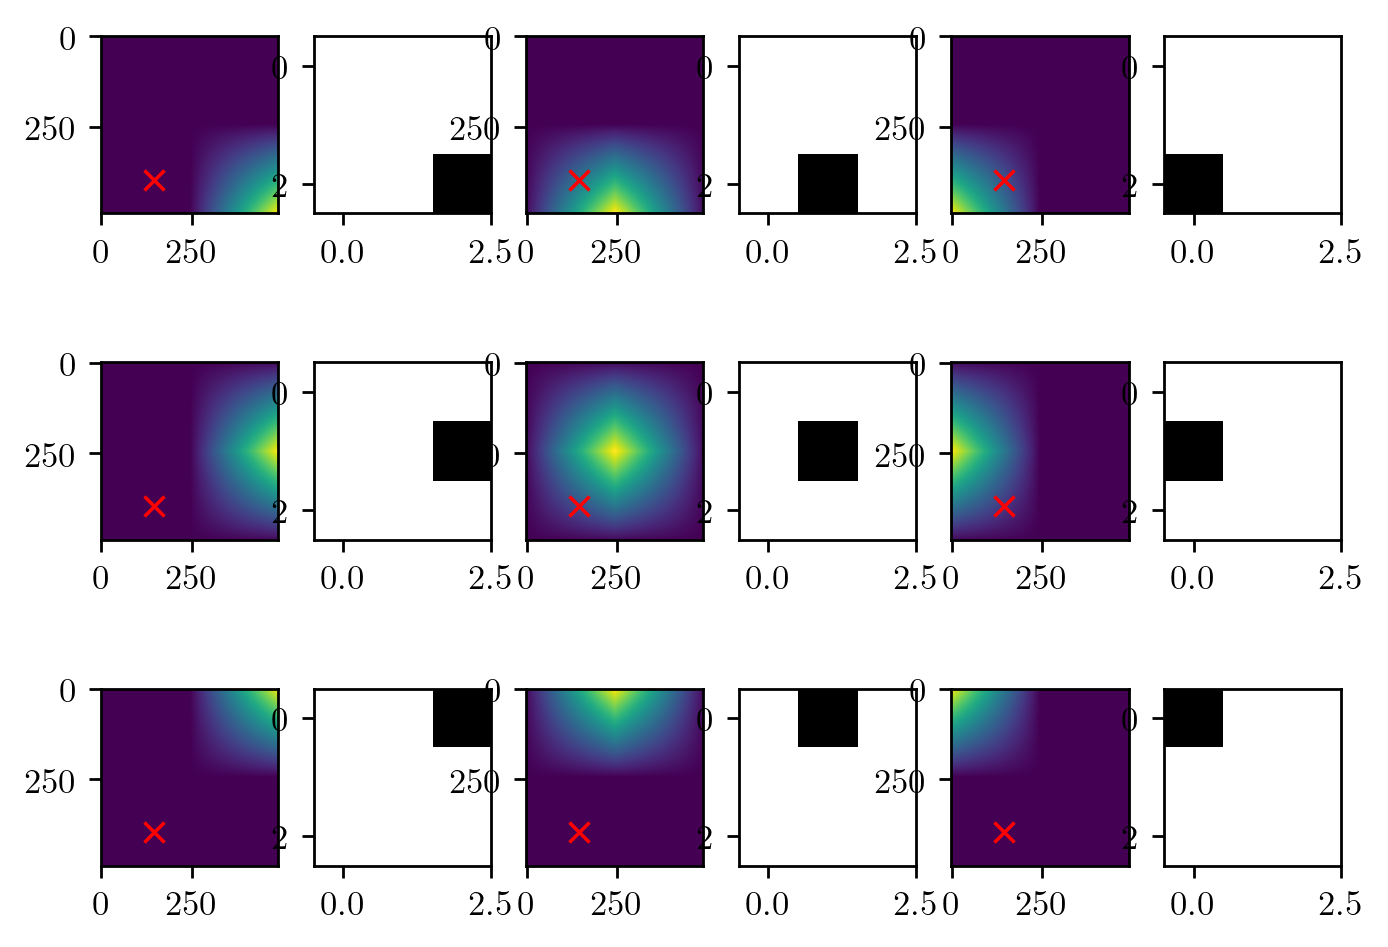

In [297]:
conv = [p for p in CG_conv.conv.parameters()][0]

maps = torch.relu(map).repeat_interleave(downsample[0],dim=2).repeat_interleave(downsample[1],dim=3)
conv = torch.flip(conv,(2,3))



posx = 400
posy = 150


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])#,vmax=vmax,vmin=-vmax)
    ax[i,0].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,1].imshow(conv.cpu().detach()[i*3,0],cmap='Greys'); 

    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,2].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0],cmap='Greys'); ax

    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,4].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0],cmap='Greys'); ax



In [298]:


def first_deriv(map,norm=2):
    #map is shape bs,nc,nx,ny
    first_deriv_x, first_deriv_y = torch.gradient(map,axis=(2,3))

    reg_loss = torch.norm(torch.concat([first_deriv_x,first_deriv_y],dim=0),p=norm)
    
    first_deriv_x2 = map[...,1:,:] - map[...,:-1,:]
    first_deriv_y2 = map[...,:,1:] - map[...,:,:-1]
    reg_loss2 = torch.norm(torch.concat([first_deriv_x2,first_deriv_y2.permute(0,1,3,2)],dim=0),p=norm)

    return reg_loss + 0.8 * reg_loss2


def calc_second_derivs2D(map):
    first_deriv_x, first_deriv_y = torch.gradient(map,axis=(2,3))
    second_deriv_xx, second_deriv_xy = torch.gradient(first_deriv_x,axis=(2,3))
    second_deriv_yx, second_deriv_yy = torch.gradient(first_deriv_y,axis=(2,3))
    return second_deriv_xx, second_deriv_xy, second_deriv_yx, second_deriv_yy



def hessian(map,norm=2):
    deriv_xx = (1/90)*torch.roll(map,3,dims=2) -(3/20)*torch.roll(map,2,dims=2) + (3/2)*torch.roll(map,1,dims=2) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=2) - (3/20)*torch.roll(map,-2,dims=2) + (1/90)*torch.roll(map,-3,dims=2)
    deriv_yy = (1/90)*torch.roll(map,3,dims=3) -(3/20)*torch.roll(map,2,dims=3) + (3/2)*torch.roll(map,1,dims=3) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=3) - (3/20)*torch.roll(map,-2,dims=3) + (1/90)*torch.roll(map,-3,dims=3)
    deriv_xy = (1/90)*torch.roll(map,(3,3),dims=(2,3)) -(3/20)*torch.roll(map,(2,2),dims=(2,3)) + (3/2)*torch.roll(map,(1,1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,-1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,-2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,-3),dims=(2,3))
    deriv_yx = (1/90)*torch.roll(map,(3,-3),dims=(2,3)) -(3/20)*torch.roll(map,(2,-2),dims=(2,3)) + (3/2)*torch.roll(map,(1,-1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,3),dims=(2,3))

    deriv_xx = deriv_xx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yy = deriv_yy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_xy = deriv_xy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yx = deriv_yx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)

    all_derivs = torch.concat([deriv_xx,deriv_xy,deriv_yx,deriv_yy],dim=0)

    reg_loss = torch.norm(all_derivs,p=norm) / all_derivs.numel()
    return reg_loss


def single_deriv(map,norm=2):
    deriv_xx = -(1/60)*torch.roll(map,3,dims=2) +(3/20)*torch.roll(map,2,dims=2) - (3/4)*torch.roll(map,1,dims=2) +  (3/4)*torch.roll(map,-1,dims=2) - (3/20)*torch.roll(map,-2,dims=2) + (1/60)*torch.roll(map,-3,dims=2)
    deriv_yy = -(1/60)*torch.roll(map,3,dims=3) +(3/20)*torch.roll(map,2,dims=3) - (3/4)*torch.roll(map,1,dims=3) +  (3/4)*torch.roll(map,-1,dims=3) - (3/20)*torch.roll(map,-2,dims=3) + (1/60)*torch.roll(map,-3,dims=3)
    deriv_xy = -(1/60)*torch.roll(map,(3,3),dims=(2,3)) +(3/20)*torch.roll(map,(2,2),dims=(2,3)) - (3/4)*torch.roll(map,(1,1),dims=(2,3)) +  (3/4)*torch.roll(map,(-1,-1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,-2),dims=(2,3)) + (1/60)*torch.roll(map,(-3,-3),dims=(2,3))
    deriv_yx = -(1/60)*torch.roll(map,(3,-3),dims=(2,3)) +(3/20)*torch.roll(map,(2,-2),dims=(2,3)) - (3/4)*torch.roll(map,(1,-1),dims=(2,3)) +  (3/4)*torch.roll(map,(-1,1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,2),dims=(2,3)) + (1/60)*torch.roll(map,(-3,3),dims=(2,3))

    deriv_xx = deriv_xx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yy = deriv_yy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_xy = deriv_xy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yx = deriv_yx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)

    reg_loss = torch.norm(torch.concat([deriv_xx,deriv_xy,deriv_yx,deriv_yy],dim=0),p=norm)

    return reg_loss
    

def l1norm(map):
    l1 = torch.norm(map,dim=1,p=1)
    l1 = l1 / torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)

    return torch.mean(l1)


def compute_penalty(C):
    # Assuming C has shape (nx, ny, 9) and center index is 4
    sparsity_penalty = torch.mean(torch.norm(C,dim=1,p=1))
    neighborhood_penalty = 0

    # Define neighbor pairs
    neighbor_pairs = [[0,1],[1,2],[2,5],[5,8],[8,7],[7,6],[6,3],[3,0]]
    
    for pair in neighbor_pairs:
        neighborhood_penalty += torch.sum(torch.abs(C[:, :, pair[0]] - C[:, :, pair[1]]))

    return sparsity_penalty + neighborhood_penalty


In [299]:
# batch_x = torch.zeros((16,final_prediction.shape[1],final_prediction.shape[2],final_prediction.shape[3])).to(device)
# batch_y = torch.zeros((16,final_prediction.shape[1],final_prediction.shape[2],final_prediction.shape[3])).to(device)

# for i in range(16):
#     sx = (i//4) * 2
#     sy = (i%4) * 2
#     batch_x[i] = torch.roll(x[0],(sx,sy),(1,2))
#     batch_y[i] = torch.roll(y[0],(sx,sy),(1,2))

batch_x = x.detach()
batch_y = y.detach()


In [300]:
batch_x.max(), batch_y.max(), batch_x.mean(), batch_y.mean()

(tensor(66.7043, device='cuda:1'),
 tensor(71.5877, device='cuda:1'),
 tensor(1., device='cuda:1'),
 tensor(0.9733, device='cuda:1'))

In [301]:
history2 = {'tl':[],'mse':[],'reg':[], 'lr':[]}


Text(0.5, 1.0, 'batch_y')

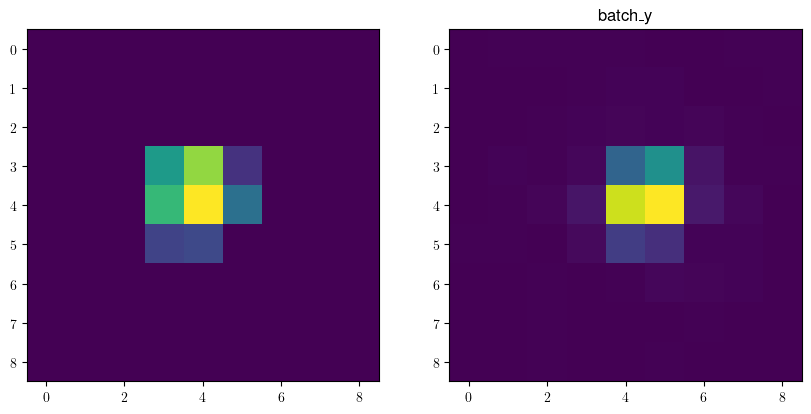

In [302]:
peak = peaks[0]

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(batch_x[0,0,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1].detach().cpu()); plt.title('batch_x')
ax[1].imshow(batch_y[0,0,peak[0]-bord:peak[0]+bord+1,peak[1]-bord:peak[1]+bord+1].detach().cpu()); plt.title('batch_y')


In [303]:
history2 = {'tl':[],'mse':[],'reg':[], 'lr':[]}
kernelsize=3

# x_disp_test = torch.rand(x_disp.shape) * 2 - 1
# y_disp_test = torch.rand(y_disp.shape) * 2 - 1

# initialiser_test = torch.concat((x_disp_test,y_disp_test),dim=1)

map = create_bilinear_coeff_map_cart_3x3(x_disp,y_disp,)

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='bilinear',initialiser = initialiser, locally_connected=True, three_d=False,downsample = downsample).to(device) 
CG_conv2 = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='bilinear',initialiser = initialiser, locally_connected=True, three_d=False,downsample = downsample).to(device) 
# CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = map, locally_connected=True, three_d=False,downsample = downsample).to(device) 

CG_conv.CG.conv.weight.data = torch.ones_like(CG_conv.CG.conv.weight.data)
CG_conv.CG.conv.bias.data = torch.zeros_like(CG_conv.CG.conv.bias.data)
CG_conv.CG.conv.requires_grad_(False)

CG_conv2.CG.conv.weight.data = torch.ones_like(CG_conv.CG.conv.weight.data)
CG_conv2.CG.conv.bias.data = torch.zeros_like(CG_conv.CG.conv.bias.data)
CG_conv2.CG.conv.requires_grad_(False)

Conv2d(9, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)

In [304]:
lr = 1e-2



epochs = 20000
# init_reg_factor = 4e-3
init_reg_factor = 1e2



wl=11
loss_fn = torch.nn.MSELoss()

all_params = list(CG_conv.parameters()) + list(CG_conv2.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)


In [305]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    # yhat_up = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)
    # # yhat_up2 = torch.concat([CG_conv2(yhat_up[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)
    # yhat = nn.functional.avg_pool2d(yhat_up,2,2)
    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)

    # dist_sin_cos = torch.concat((CG_conv.CG.map[:,1:2] , torch.sin(CG_conv.CG.map[:,0:1]) * 1/2 , torch.cos(CG_conv.CG.map[:,0:1]) * 1/2),dim=1)
    # reg = hessian(dist_sin_cos,norm=1) 
    reg = hessian(CG_conv.CG.map[:],norm=1) #+ hessian(CG_conv2.CG.map[:],norm=1) 

    # reg0 = hessian(CG_conv.CG.map[:,1:2],norm=1) #+ l1norm(CG_conv.CG.map[:,except_middle])*100

    # yhat[yhat < yhat.max() * 0.1] = 0

    mse = loss_fn(yhat,batch_y)
    loss =  mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.CG.parameters()):
            if n==0:
                parameter[:,0].clamp_(min=-1,max=1)
                parameter[:,1].clamp_(min=-1,max=1)

        for n,parameter in enumerate(CG_conv2.CG.parameters()):
            if n==0:
                parameter[:,0].clamp_(min=-1,max=1)
                parameter[:,1].clamp_(min=-1,max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    # print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g},   epoch time: {total_time_sec:5.5g}',end='\r')
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')

    
    history2['mse'].append(mse.data.item())
    history2['reg'].append((init_reg_factor*reg).data.item())

KeyboardInterrupt: 

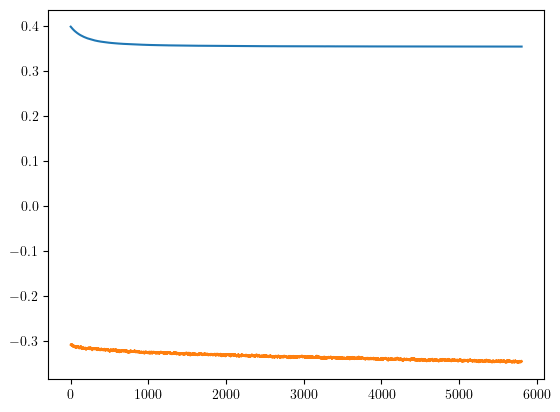

In [306]:
plt.plot(np.log10(history2['mse'])[100:])
plt.plot(np.log10(history2['reg'])[100:])

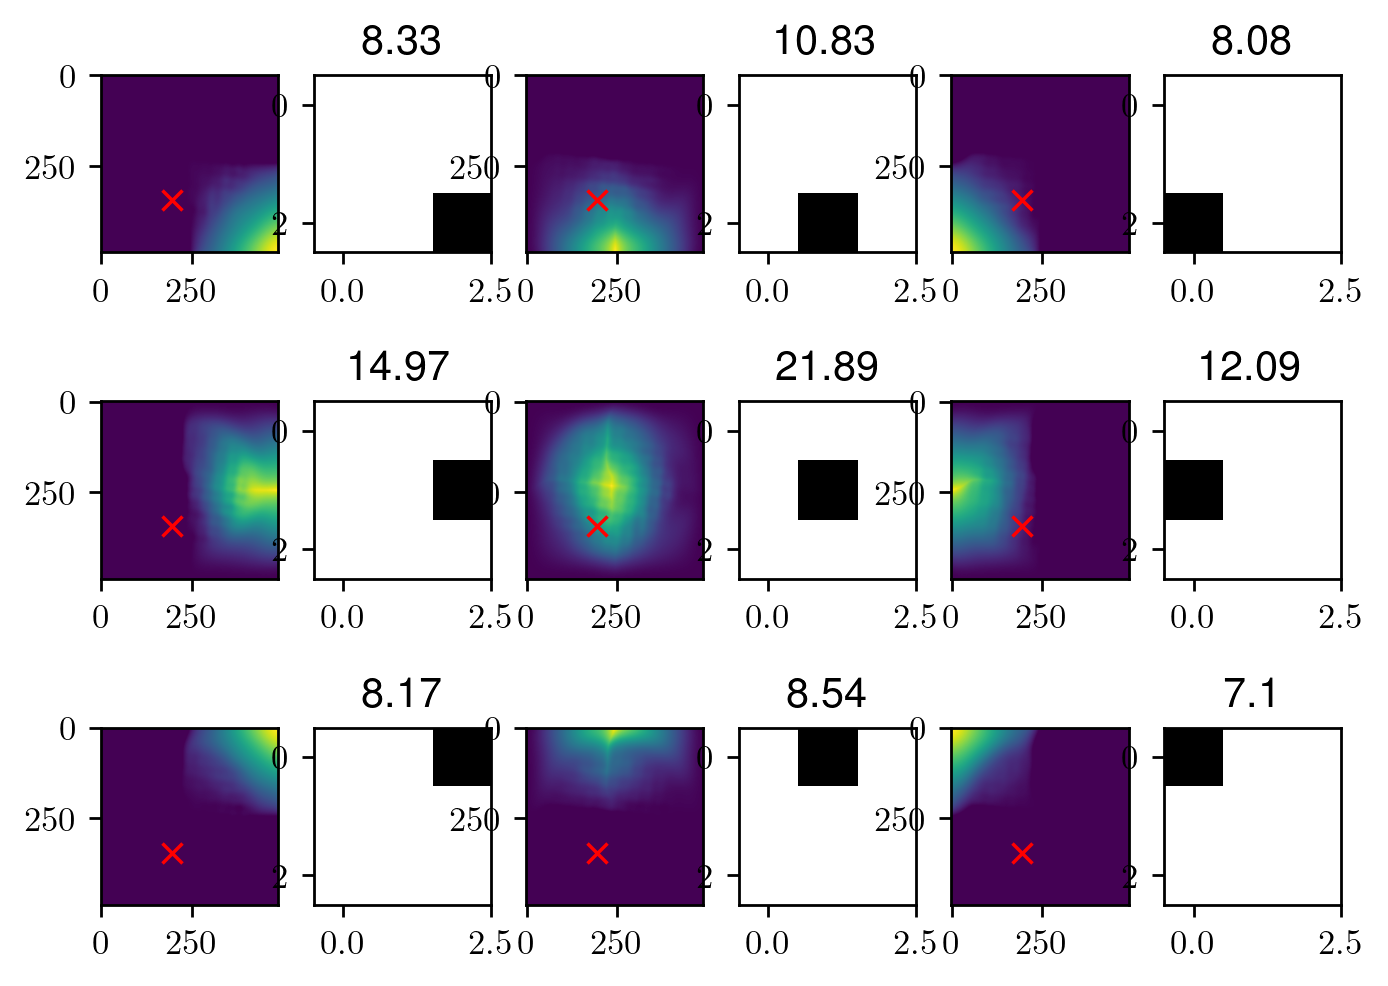

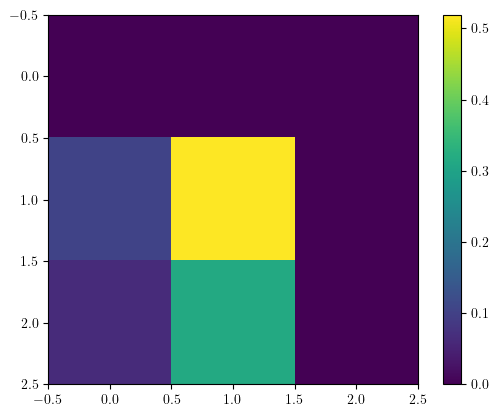

In [307]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]

maps = create_bilinear_coeff_map_cart_3x3(maps[:,0:1],maps[:,1:2])

maps = torch.relu(maps).repeat_interleave(downsample[0],dim=2).repeat_interleave(downsample[1],dim=3)


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()

conv = torch.flip(conv,(2,3))

posx = 350
posy = 200


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])#,vmax=vmax,vmin=-vmax)
    ax[i,0].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,1].imshow(conv.cpu().detach()[i*3,0],cmap='Greys'); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))

    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,2].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0],cmap='Greys'); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))

    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,4].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0],cmap='Greys'); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))


plt.figure()
plt.imshow(torch.sum(conv.data[:,0] * maps[0,:,posx,posy][:,None,None],dim=0).detach().cpu()); plt.colorbar()

In [308]:
lr = 1e-2



epochs = 20000
# init_reg_factor = 4e-3
init_reg_factor = 1e1



wl=11
loss_fn = torch.nn.MSELoss()

all_params = list(CG_conv.parameters()) + list(CG_conv2.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)


In [277]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat_up = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)
    yhat_up2 = torch.concat([CG_conv2(yhat_up[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)
    yhat = nn.functional.avg_pool2d(yhat_up2,2,2)

    reg = hessian(CG_conv.CG.map[:],norm=1) + hessian(CG_conv2.CG.map[:],norm=1) 


    mse = loss_fn(yhat,batch_y)
    loss =  mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.CG.parameters()):
            if n==0:
                parameter[:,0].clamp_(min=-1,max=1)
                parameter[:,1].clamp_(min=-1,max=1)

        for n,parameter in enumerate(CG_conv2.CG.parameters()):
            if n==0:
                parameter[:,0].clamp_(min=-1,max=1)
                parameter[:,1].clamp_(min=-1,max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    # print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g},   epoch time: {total_time_sec:5.5g}',end='\r')
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')

    
    history2['mse'].append(mse.data.item())
    history2['reg'].append((init_reg_factor*reg).data.item())

KeyboardInterrupt: 

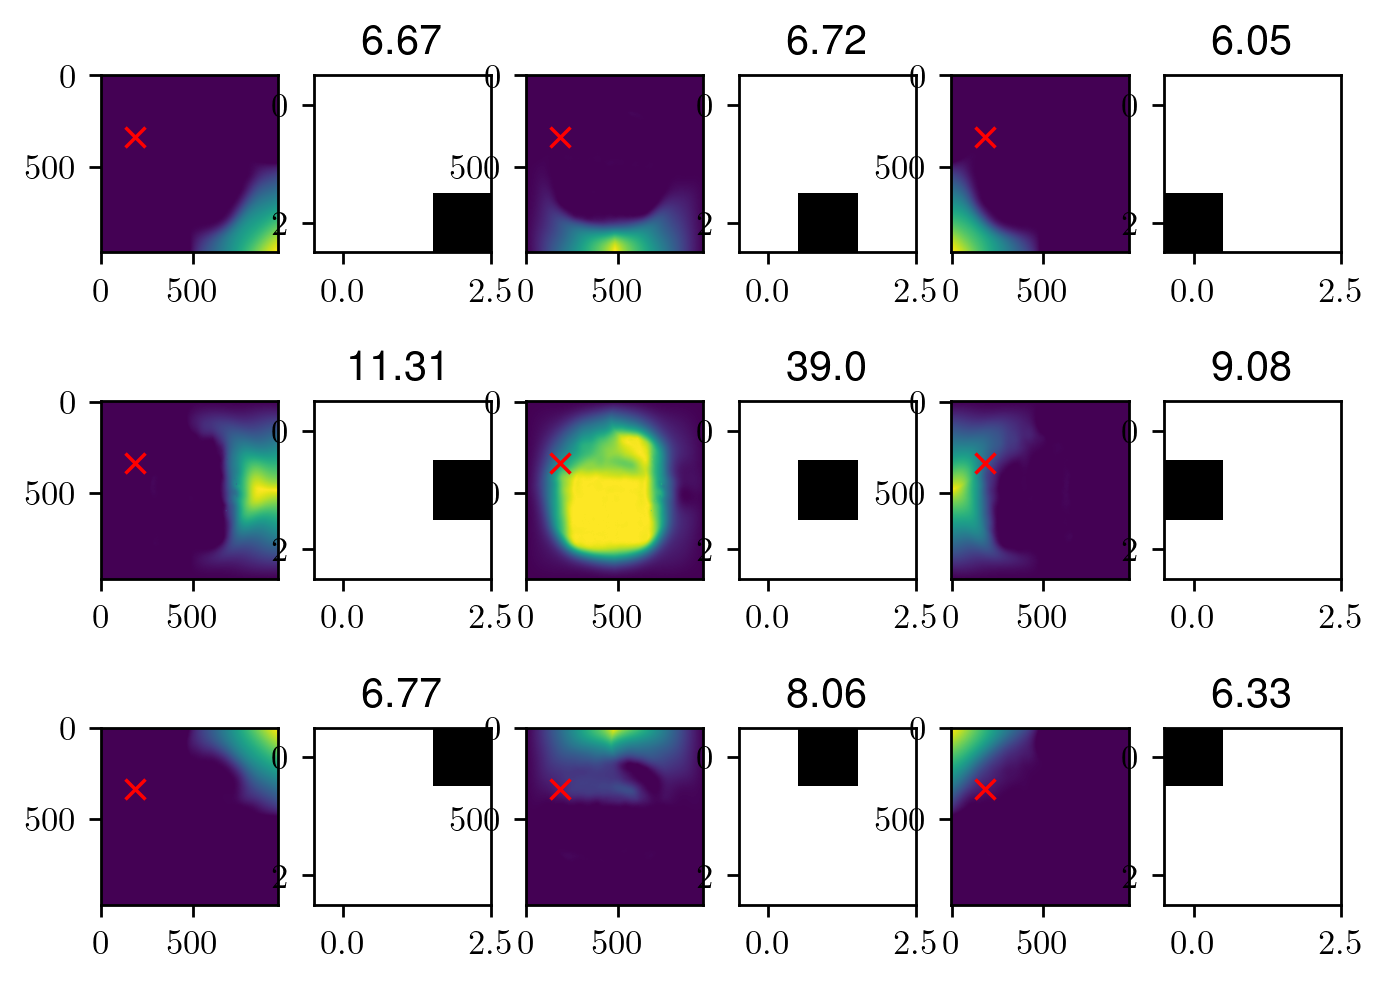

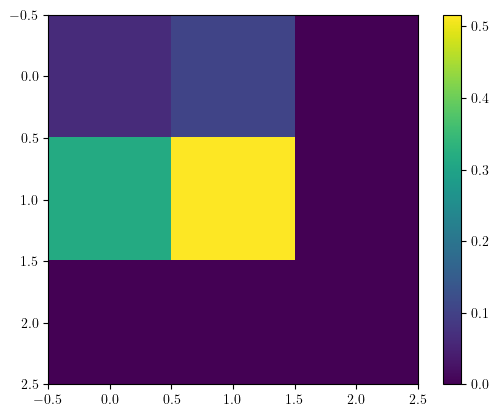

In [278]:
conv = [p for p in CG_conv2.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv2.CG.parameters()][:2]

maps = create_bilinear_coeff_map_cart_3x3(maps[:,0:1],maps[:,1:2])

maps = torch.relu(maps).repeat_interleave(downsample[0],dim=2).repeat_interleave(downsample[1],dim=3)


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()

conv = torch.flip(conv,(2,3))

posx = 350
posy = 200


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])#,vmax=vmax,vmin=-vmax)
    ax[i,0].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,1].imshow(conv.cpu().detach()[i*3,0],cmap='Greys'); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))

    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,2].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0],cmap='Greys'); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))

    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2,3*downsample[0]:-3*downsample[0],3*downsample[1]:-3*downsample[1]])
    ax[i,4].plot(posy - 3*downsample[1],posx - 3*downsample[0],'rx')
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0],cmap='Greys'); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))


plt.figure()
plt.imshow(torch.sum(conv.data[:,0] * maps[0,:,posx,posy][:,None,None],dim=0).detach().cpu()); plt.colorbar()

In [309]:
torch.sum(conv.data[:,0] * maps[0,:,posx,posy][:,None,None],dim=0).detach().cpu()

tensor([[0.0000, 0.0000, 0.0000],
        [0.1036, 0.5189, 0.0000],
        [0.0628, 0.3147, 0.0000]])

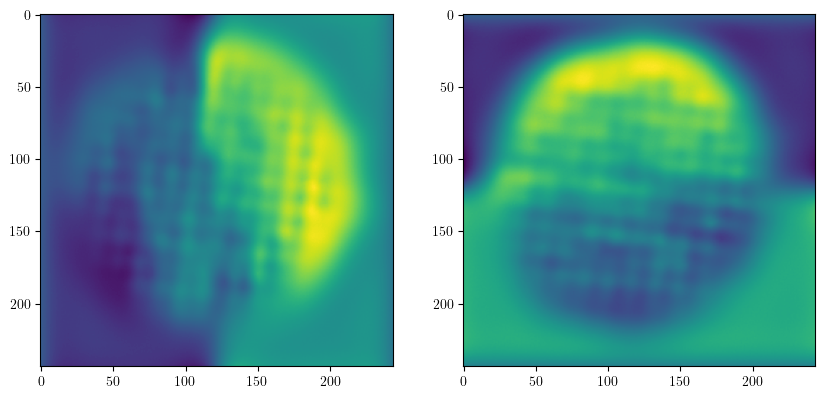

In [310]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow((CG_conv.CG.map[0,0].cpu() - initialiser[0,0]).detach()[3:-3,3:-3])
ax[1].imshow((CG_conv.CG.map[0,1].cpu() - initialiser[0,1]).detach()[3:-3,3:-3])

In [311]:
# fig,ax = plt.subplots(1,4,figsize=(10,5))
# im0 = ax[0].imshow(CG_conv.CG.map[0,0].detach().cpu()[3:-3,3:-3])
# im1 = ax[1].imshow(torch.sin(CG_conv.CG.map[0,0].detach().cpu()[3:-3,3:-3]))
# im2 = ax[2].imshow(torch.cos(CG_conv.CG.map[0,0].detach().cpu()[3:-3,3:-3]))
# im3 = ax[3].imshow(CG_conv.CG.map[0,1].detach().cpu()[3:-3,3:-3])

# fig.colorbar(im0, ax=ax[0])  # Add colorbar to first subplot
# fig.colorbar(im1, ax=ax[1])  # Add colorbar to first subplot
# fig.colorbar(im2, ax=ax[2])  # Add colorbar to first subplot
# fig.colorbar(im3, ax=ax[3])  # Add colorbar to first subplot


/tmp/user/25186/ipykernel_2104715/1702292881.py:2: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0].imshow(x[0,0,2*(posx-25):2*(posx+25),2*(posy-25):2*(posy+25)].detach().cpu()); ax[0].set_title('original')


Text(0.5, 1.0, 'measurement')

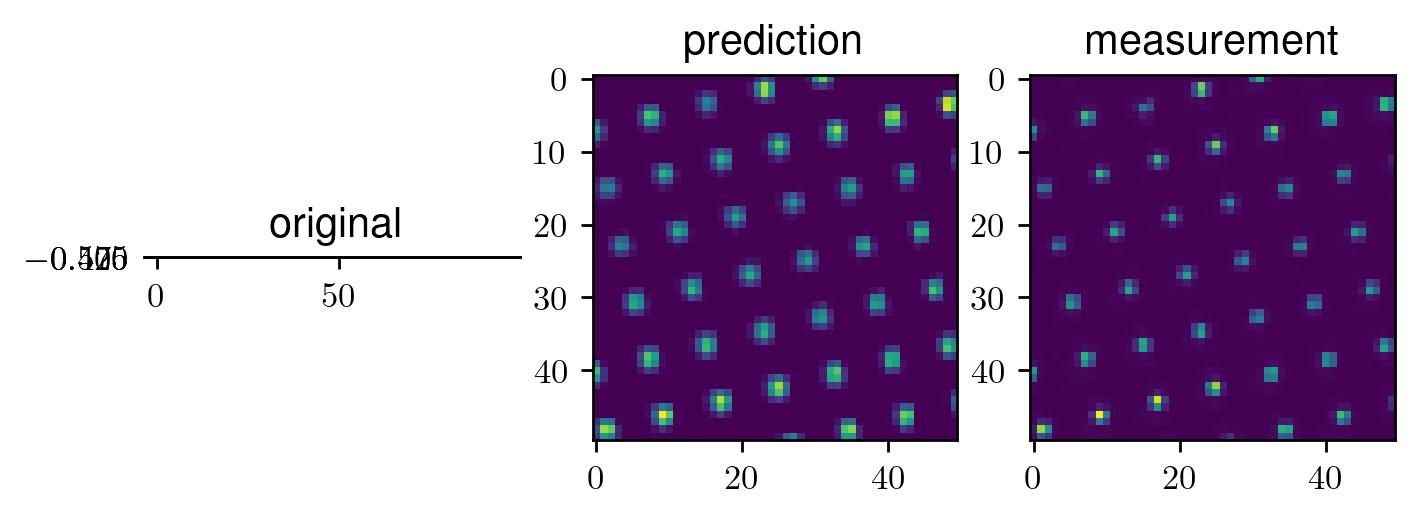

In [312]:
fig,ax = plt.subplots(1,3,dpi=250)
ax[0].imshow(x[0,0,2*(posx-25):2*(posx+25),2*(posy-25):2*(posy+25)].detach().cpu()); ax[0].set_title('original')
# ax[0].imshow(x[0,0,(posx-25):(posx+25),(posy-25):(posy+25)].detach().cpu()); ax[0].set_title('original')
ax[1].imshow(yhat[0,0,posx-25:posx+25,posy-25:posy+25].detach().cpu()); ax[1].set_title('prediction')
ax[2].imshow(batch_y[0,0,posx-25:posx+25,posy-25:posy+25].detach().cpu()); ax[2].set_title('measurement')

In [99]:
yhat[0,0,posx-25:posx+25,posy-25:posy+25].detach().cpu().max(), batch_y[0,0,posx-25:posx+25,posy-25:posy+25].detach().cpu().max()

(tensor(36.1863), tensor(67.2574))

Text(0.5, 1.0, 'measurement')

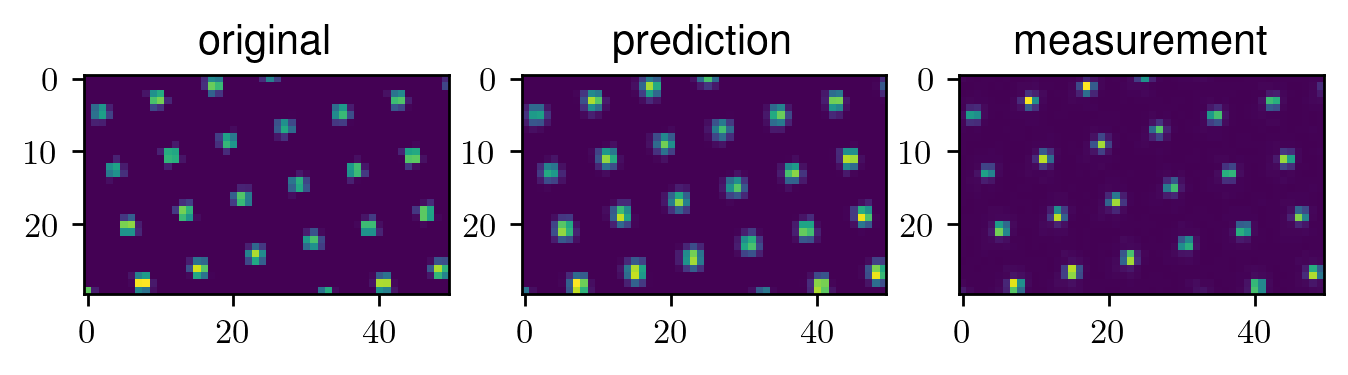

In [313]:
fig,ax = plt.subplots(1,3,dpi=250)
# ax[0].imshow(x[0,0,2*(posx-15):2*(posx+15),2*(posy-25):2*(posy+25)].detach().cpu()); ax[0].set_title('original')
ax[0].imshow(x[0,0,(posx-15):(posx+15),(posy-25):(posy+25)].detach().cpu()); ax[0].set_title('original')
ax[1].imshow(yhat[0,0,posx-15:posx+15,posy-25:posy+25].detach().cpu()); ax[1].set_title('prediction')
ax[2].imshow(batch_y[0,0,posx-15:posx+15,posy-25:posy+25].detach().cpu()); ax[2].set_title('measurement')

Text(0.5, 1.0, 'measurement')

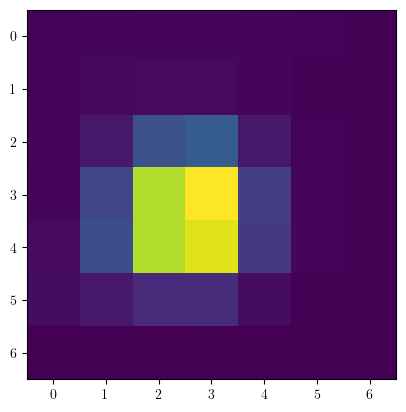

In [83]:
plt.imshow(shift(batch_y[0,0,posx-2:posx+5,posy-7:posy].detach().cpu(),order=1,shift=(-0.4,-0.4))); ax[2].set_title('measurement')

orig error: 0.4624207199999998, upsampled error: 0.019346080000000085


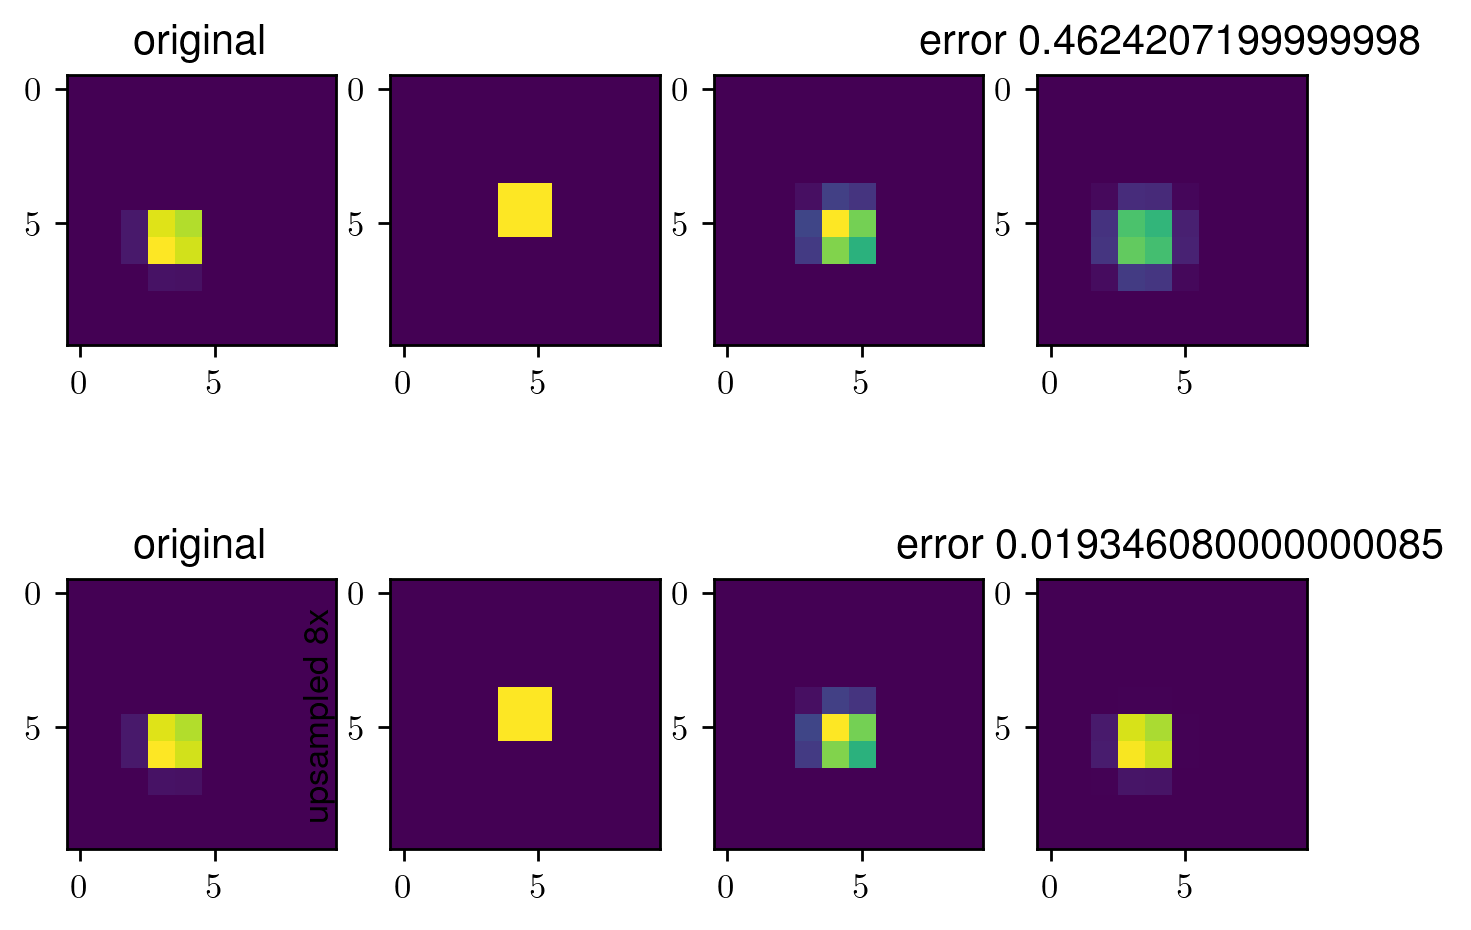

In [342]:
from skimage.measure import block_reduce

shift1 = np.array([0.81,-0.21])
shift2 = np.array([0.24,-0.86])


a = np.zeros((10,10))
a[4:6,4:6] = 1
GT = shift(a,order=1,shift = shift1 + shift2)


fig,ax = plt.subplots(2,4,dpi=250)
ax[0,1].imshow(a)
b = shift(a,order=1,shift=shift1)
ax[0,2].imshow(b,vmax=1)
c = shift(b,order=1,shift=shift2)
ax[0,3].imshow(c,vmax=1); ax[0,3].set_title(f'error {np.sum(np.abs(GT - c)) / 4}')
ax[0,0].imshow(GT,vmax=1); ax[0,0].set_title('original')

upsample_factor = 8

a_up = np.zeros((10*upsample_factor,10*upsample_factor))
a_up[4*upsample_factor:6*upsample_factor,4*upsample_factor:6*upsample_factor] = 1
ax[1,1].imshow(block_reduce(a_up, upsample_factor, np.mean),vmax=1); ax[1,1].set_ylabel(f'upsampled {upsample_factor}x')
b_up = shift(a_up,order=1,shift=upsample_factor*shift1)
ax[1,2].imshow(block_reduce(b_up, upsample_factor, np.mean),vmax=1)
c_up = shift(b_up,order=1,shift=upsample_factor*shift2)
ax[1,3].imshow(block_reduce(c_up, upsample_factor, np.mean),vmax=1); ax[1,3].set_title(f'error {np.sum(np.abs(GT - block_reduce(c_up, upsample_factor, np.mean))) / 4}')

ax[1,0].imshow(GT,vmax=1); ax[1,0].set_title('original')



print(f'orig error: {np.sum(np.abs(GT - c)) / 4}, upsampled error: {np.sum(np.abs(GT - block_reduce(c_up, upsample_factor, np.mean))) / 4}')


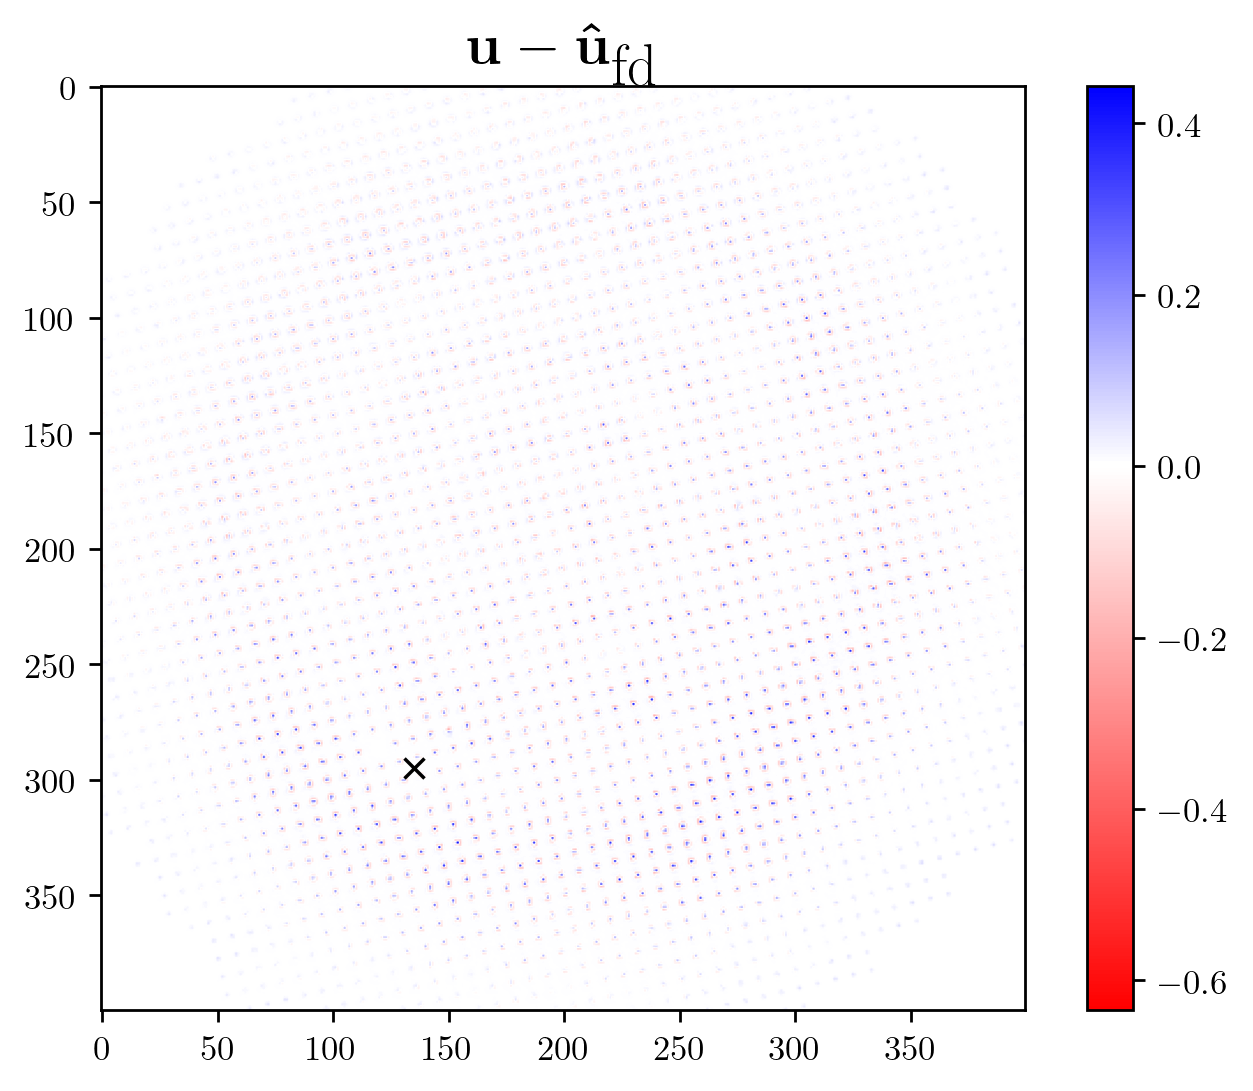

In [64]:
from scipy.ndimage import gaussian_filter


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.figure(dpi=250)
import matplotlib


# red = np.array([1,0,0])
# white = np.array([1,1,1])
# blue = np.array([0,0,1])

# colors = []
# for i in np.linspace(0,1,50):
#     colors.append(  (1-i) * red + (i) * white)             
# for i in np.linspace(0,1,50):
#     colors.append(  (1-i) * white + (i) * blue)

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)


truth = yhat[0,0] / y[0,0].max()
measurement = y[0,0] / y[0,0].max()

corrected = truth[50:450,40:440]
measurement = measurement[50:450,40:440]

diff = ((measurement - corrected)).detach().cpu().numpy()

# vmax = np.abs(diff).max()

# ,vmax = vmax_diff*0.7,vmin=-vmax_diff

# plt.imshow(diff,cmap=cmap,vmax = vmax*0.5,vmin=-vmax*0.5); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\hat{u}}_{\textrm{fd}}$',fontsize=15)
# plt.imshow(diff,cmap='RdBu',vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\hat{u}}_{\textrm{fd}}$',fontsize=17)
plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\hat{u}}_{\textrm{fd}}$',fontsize=17)
plt.plot(posy - 3*downsample[1] - 50,posx - 3*downsample[0] - 40,'kx')

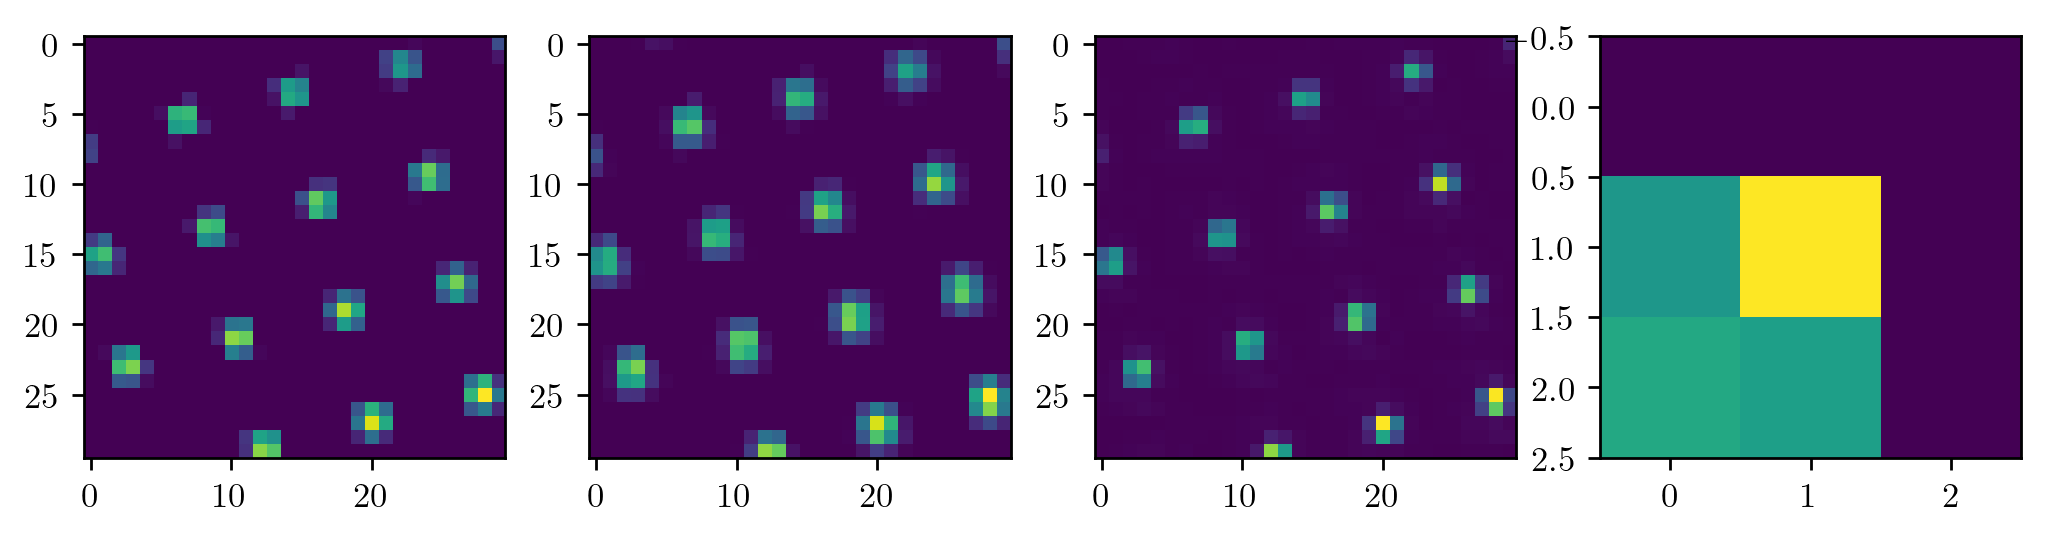

In [394]:
original = batch_x[0,0,50:450,40:440]

fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=250)
ax[0].imshow(original.detach().cpu()[300:330,200:230],)
ax[1].imshow(corrected.detach().cpu()[300:330,200:230],)
ax[2].imshow(measurement.detach().cpu()[300:330,200:230],)
ax[3].imshow(torch.sum(conv.data[:,0] * maps[0,:,posx,posy][:,None,None],dim=0).detach().cpu())



In [109]:
CG_channels = 3
kernelsize = 7

downsample = [5,5]

initialiser = torch.ones((1,CG_channels,mask_funda.shape[2]//downsample[0],mask_funda.shape[3]//downsample[1]))
initialiser = initialiser / CG_channels

CG_conv2 = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False, parameter_conv=True, three_d=False,downsample=downsample).to(device) 

g_maker = gaussian_maker(kernelsize=kernelsize, n_channels=CG_channels, device=device)

CG_conv2.CG.conv.weight.data = torch.ones_like(CG_conv2.CG.conv.weight.data)
CG_conv2.CG.conv.bias.data = torch.zeros_like(CG_conv2.CG.conv.bias.data)
CG_conv2.CG.conv.requires_grad_(False)




# conv1 = torch.nn.Conv2d(1,1,kernel_size=kernelsize,padding=kernelsize//2,bias=False).to(device)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)

In [122]:
lr = 5e-4



epochs = 10000
init_reg_factor2 = 1e-2

wl=11
loss_fn = torch.nn.MSELoss()
all_params = list(CG_conv.parameters()) + list(CG_conv2.parameters()) + list(g_maker.parameters()) #+ list(conv1.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)

# # cor1 = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1).detach()


In [123]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    gaussians = g_maker()   
    cor1 = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)
    yhat = torch.concat([CG_conv2((cor1[:,i:i+1], gaussians)) for i in range(batch_x.shape[1])],dim=1)
    # yhat = torch.concat([conv1(cor1[:,i:i+1]) for i in range(batch_x.shape[1])],dim=1)

    # 
    # yhat = torch.concat([CG_conv2((cor1[:,i:i+1],gaussians)) for i in range(cor1.shape[1])],dim=1)
    # yhat = torch.concat([CG_conv(cor1[:,i:i+1]) for i in range(cor1.shape[1])],dim=1)



    reg = hessian(CG_conv.CG.map,norm=2)
    reg2 = hessian(CG_conv2.CG.map,norm=2)

    # # masked_cgmap = CG_conv.CG.map * mask[None,None,...]
    # reg = hessian(CG_conv.CG.map,mask)
    # reg2 = hessian(CG_conv2.CG.map,mask)


    mse = loss_fn(yhat,batch_y)
    # mse = loss_fn(yhat[...,mask],batch_y[...,mask])
    loss =  mse + reg * init_reg_factor + reg2 * init_reg_factor2 

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)

        # for n,parameter in enumerate(conv1.parameters()):
        #     parameter.clamp_(min=0)

        for n,parameter in enumerate(CG_conv2.CG.parameters()):
            if n!=0:
                parameter.clamp_(min=0)
                

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}',end='\r')#,train reg2: {reg2:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

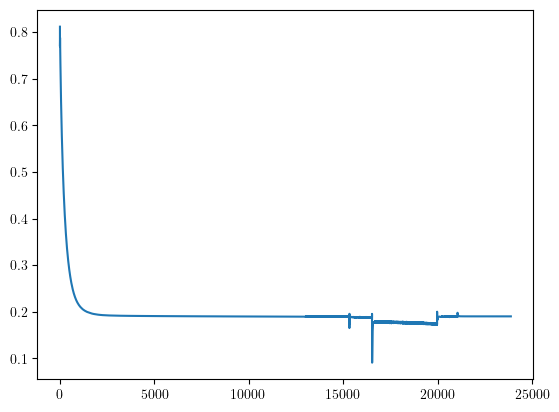

In [124]:
plt.plot(np.log10(history2['mse']))

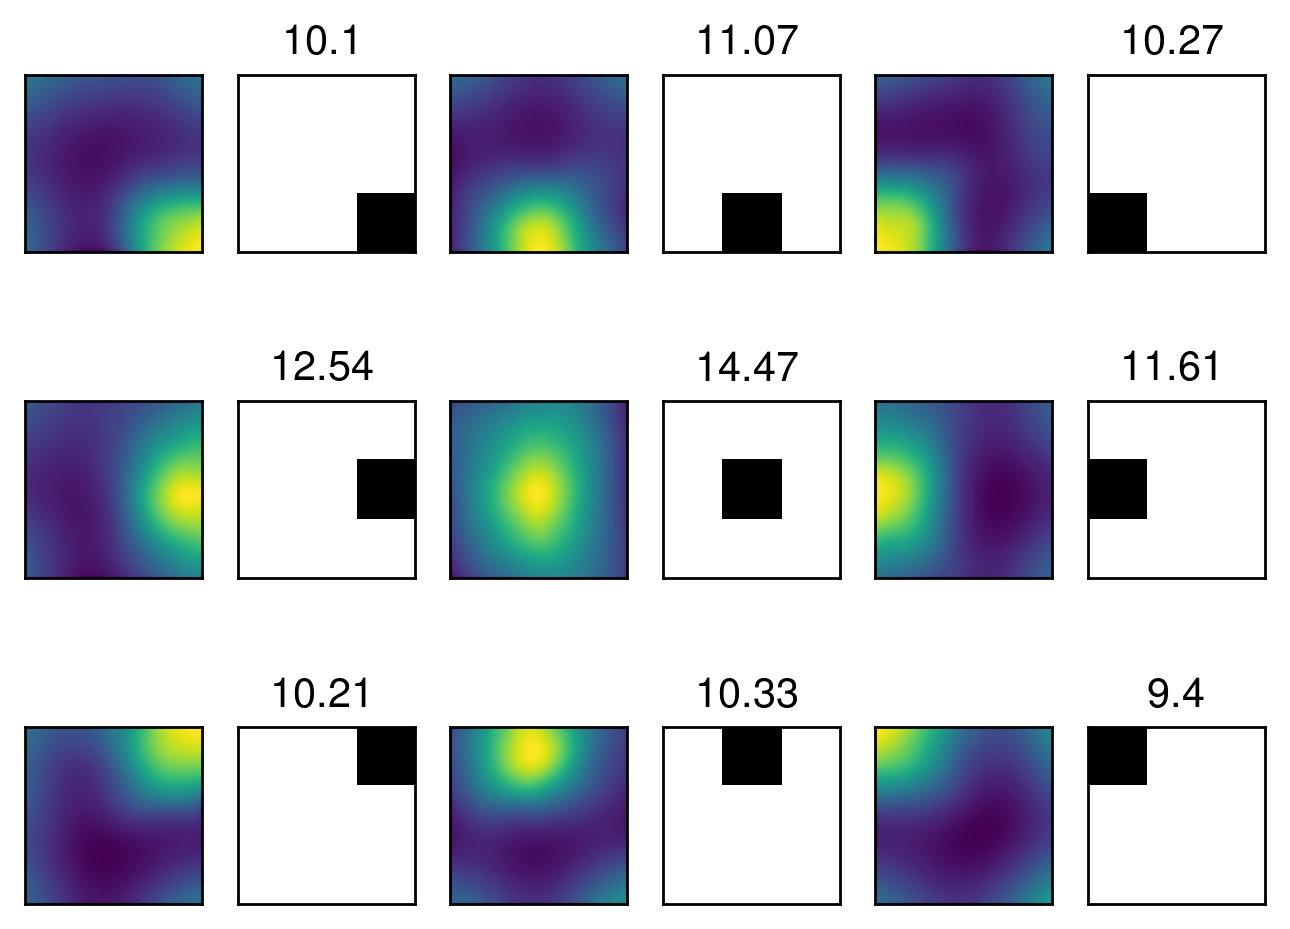

In [125]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3,3:-3,3:-3]);ax[i,0].set_xticks([]); ax[i,0].set_yticks([])
    ax[i,1].imshow(torch.flip(conv,dims=[2,3]).cpu().detach()[i*3,0],cmap='Greys'); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2)); ax[i,1].set_xticks([]); ax[i,1].set_yticks([])
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1,3:-3,3:-3]); ax[i,2].set_xticks([]); ax[i,2].set_yticks([])
    ax[i,3].imshow(torch.flip(conv,dims=[2,3]).cpu().detach()[i*3+1,0],cmap='Greys'); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2)); ax[i,3].set_xticks([]); ax[i,3].set_yticks([])
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2,3:-3,3:-3]); ax[i,4].set_xticks([]); ax[i,4].set_yticks([])
    ax[i,5].imshow(torch.flip(conv,dims=[2,3]).cpu().detach()[i*3+2,0],cmap='Greys'); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2)); ax[i,5].set_xticks([]); ax[i,5].set_yticks([])

IndexError: index 3 is out of bounds for dimension 1 with size 3

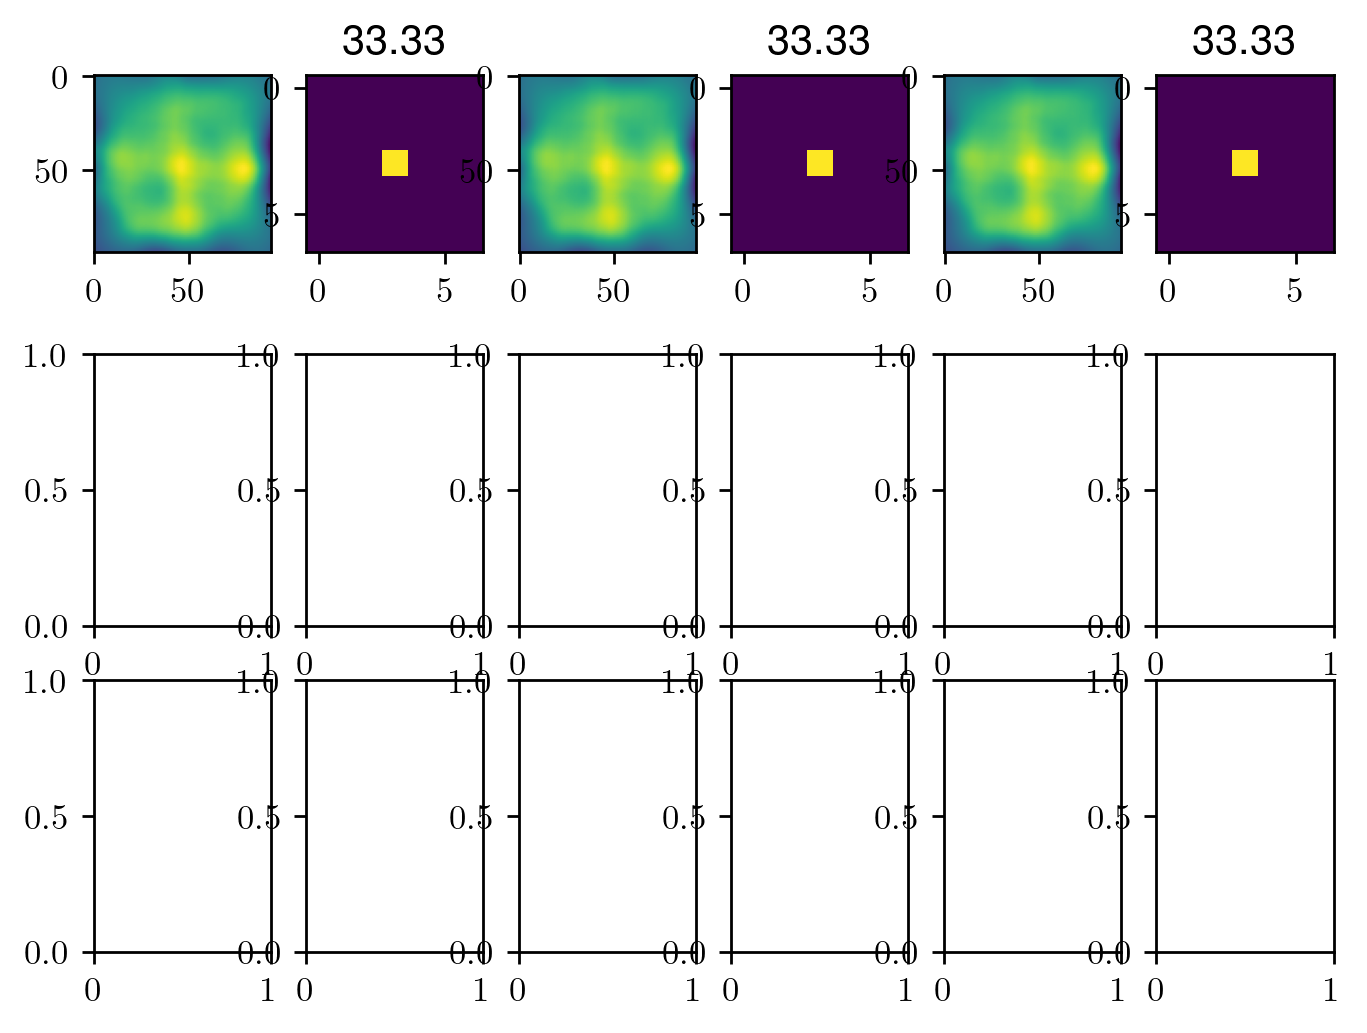

In [126]:
# conv = [p for p in CG_conv2.conv.parameters()][0]#gaussians
conv = gaussians
maps,coeffs = [p for p in CG_conv2.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3,3:-3,3:-3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1,3:-3,3:-3])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2,3:-3,3:-3])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{\\hat{u}}_{\\textrm{fd}}$')

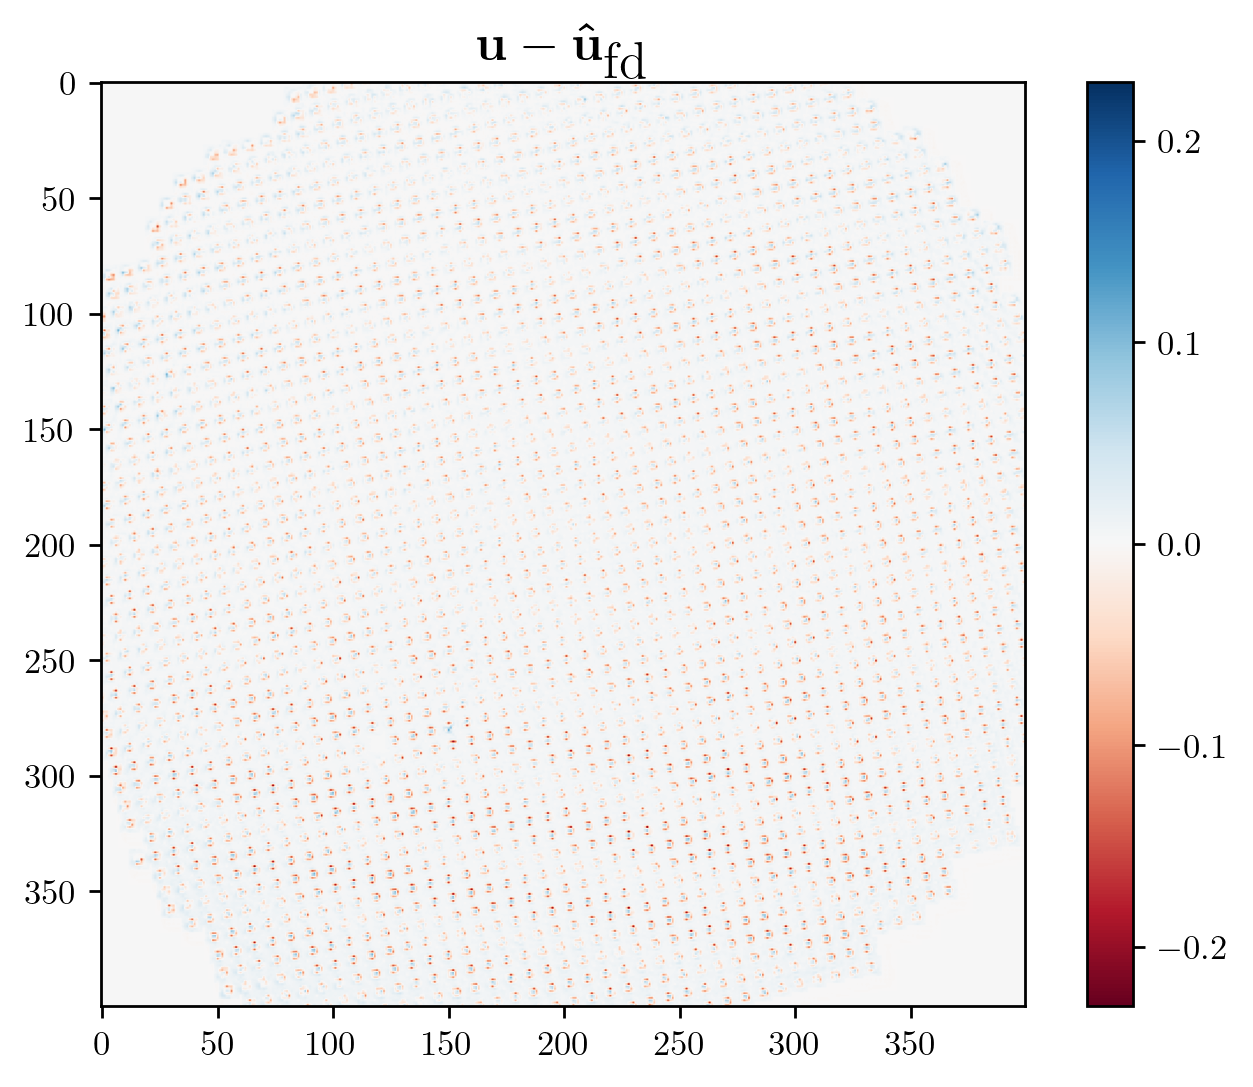

In [135]:
from scipy.ndimage import gaussian_filter


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.figure(dpi=250)
import matplotlib


red = np.array([1,0,0])
white = np.array([1,1,1])
blue = np.array([0,0,1])

colors = []
for i in np.linspace(0,1,50):
    colors.append(  (1-i) * red + (i) * white)             
for i in np.linspace(0,1,50):
    colors.append(  (1-i) * white + (i) * blue)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)


truth = yhat[0,0] / y[0,0].max()
measurement = y[0,0] / y[0,0].max()

corrected = truth[50:450,40:440]
measurement = measurement[50:450,40:440]

diff = ((measurement - corrected)).detach().cpu().numpy()

vmax = np.abs(diff).max()



# plt.imshow(diff,cmap=cmap,vmax = vmax*0.5,vmin=-vmax*0.5); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\hat{u}}_{\textrm{fd}}$',fontsize=15)
plt.imshow(diff,cmap='RdBu',vmax = vmax,vmin=-vmax); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\hat{u}}_{\textrm{fd}}$',fontsize=15)

In [136]:
g_maker.gauss_params

Parameter containing:
tensor([[[-0.0148, -0.0140],
         [-0.0250, -0.0267],
         [-0.0222, -0.0202]],

        [[ 0.0261,  0.0262],
         [ 0.0216,  0.0219],
         [ 0.0192,  0.0203]]], device='cuda:1', requires_grad=True)

In [603]:
maps.min()

tensor(-1.8113, device='cuda:1', grad_fn=<MinBackward1>)

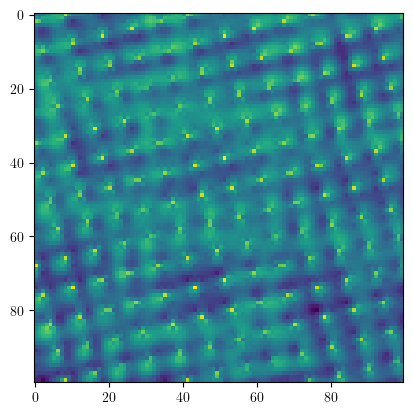

In [604]:
plt.imshow(maps.cpu().detach()[0,0*3,200:-200,200:-200])


### Try with FCN CG

In [51]:
history2= {}
history2['tl'] = []
history2['mse'] = []
history2['reg'] = []
history2['lr'] = []

In [757]:
kernelsize = 3
CG_channels = 9

final_prediction = final_prediction / final_prediction.mean()
mask_funda_wl = mask_funda_wl / mask_funda_wl.mean()

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='pos',encoding_layers = 2,locally_connected=True).to(device)

In [758]:
lr = 5e-3



epochs = 8000
init_reg_factor = 5e-3

wl=11

all_params = list(CG_conv.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)




In [759]:
list(CG_conv.conv.parameters())[1]

Parameter containing:
tensor([-0.1430,  0.3024, -0.3172, -0.2813,  0.0051, -0.2958,  0.3280,  0.2209,
         0.2242], device='cuda:1', requires_grad=True)

In [760]:



start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    # yhat = CG_conv(final_prediction[:,wl:wl+1])
    yhat = torch.concat([CG_conv(final_prediction[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)


    mse = loss_fn(yhat,mask_funda_wl)
    loss =  mse 

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for p in CG_conv.CG.conv.parameters():
            p.clamp_(min=0)
            


    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g} epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)


KeyboardInterrupt: 

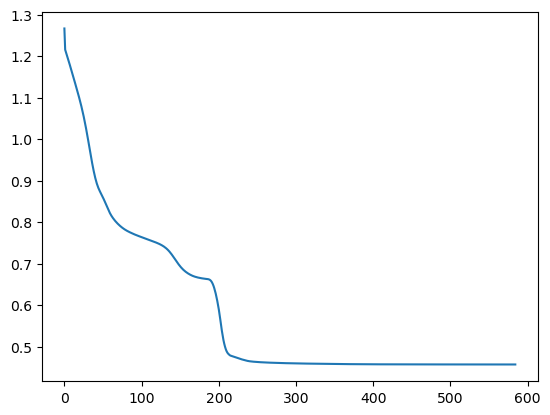

In [761]:
plt.plot(np.log10(history2['mse']))

In [762]:
CG_conv.conv

Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [763]:
coeffs.min()

tensor(0., device='cuda:1', grad_fn=<MinBackward1>)

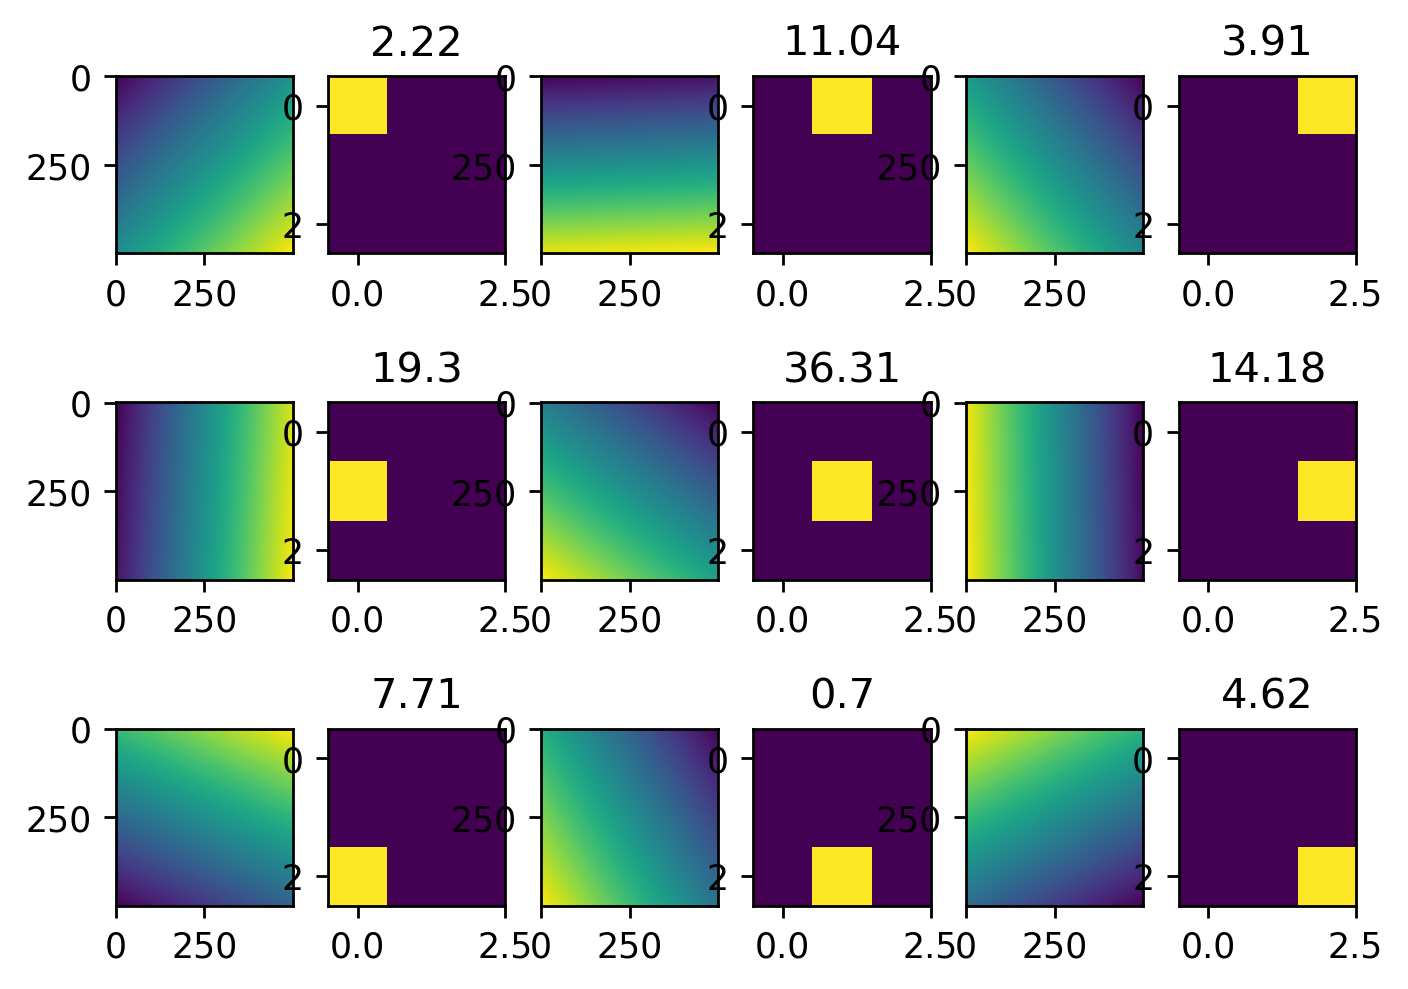

In [764]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps = CG_conv.CG.encoder(CG_conv.CG.pos).view(1,500,500,9).permute(0,3,1,2)
coeffs = CG_conv.CG.conv.weight
# maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * torch.relu(maps).mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

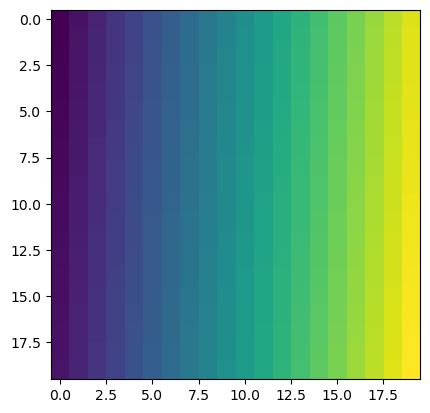

In [765]:
plt.imshow(maps[0,3,230:250,240:260].cpu().detach())

In [790]:
CG_channels = 9
kernelsize = 3



# initialiser = torch.rand((1,CG_channels,mask_nograting_funda.shape[2],mask_nograting_funda.shape[3]))
initialiser = torch.ones((1,CG_channels,mask_funda.shape[2],mask_funda.shape[3]))
initialiser = initialiser / CG_channels

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=True, three_d=False).to(device) 


In [791]:
CG_conv.CG.map.data = maps

In [792]:
lr = 5e-2
optimizer = torch.optim.Adam(CG_conv.CG.parameters(), lr=lr)
init_reg_factor = 5e-5

tensor(7.6210, device='cuda:1', grad_fn=<MeanBackward0>)

In [798]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)



    reg1 = hessian(CG_conv.CG.map,norm=1)
    reg2 = torch.mean(torch.norm(CG_conv.CG.map,dim=(1),p=1))


    reg = reg1 + reg2


    mse = loss_fn(yhat,batch_y)
    loss =  mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)
            # else:
                # parameter.clamp_(max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

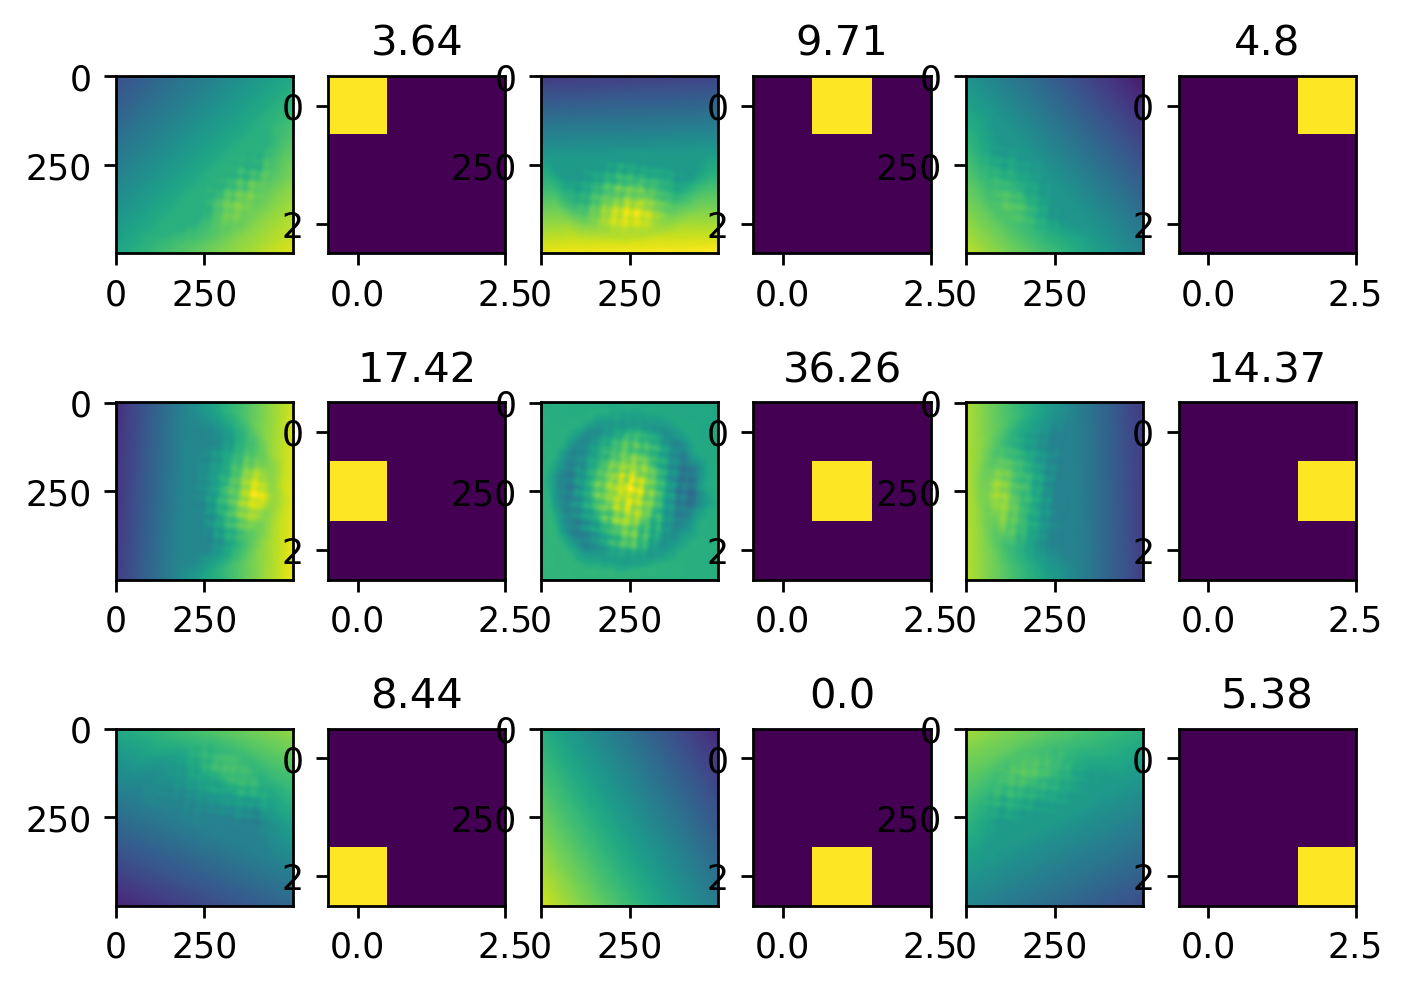

In [799]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * torch.relu(maps).mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 3
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))

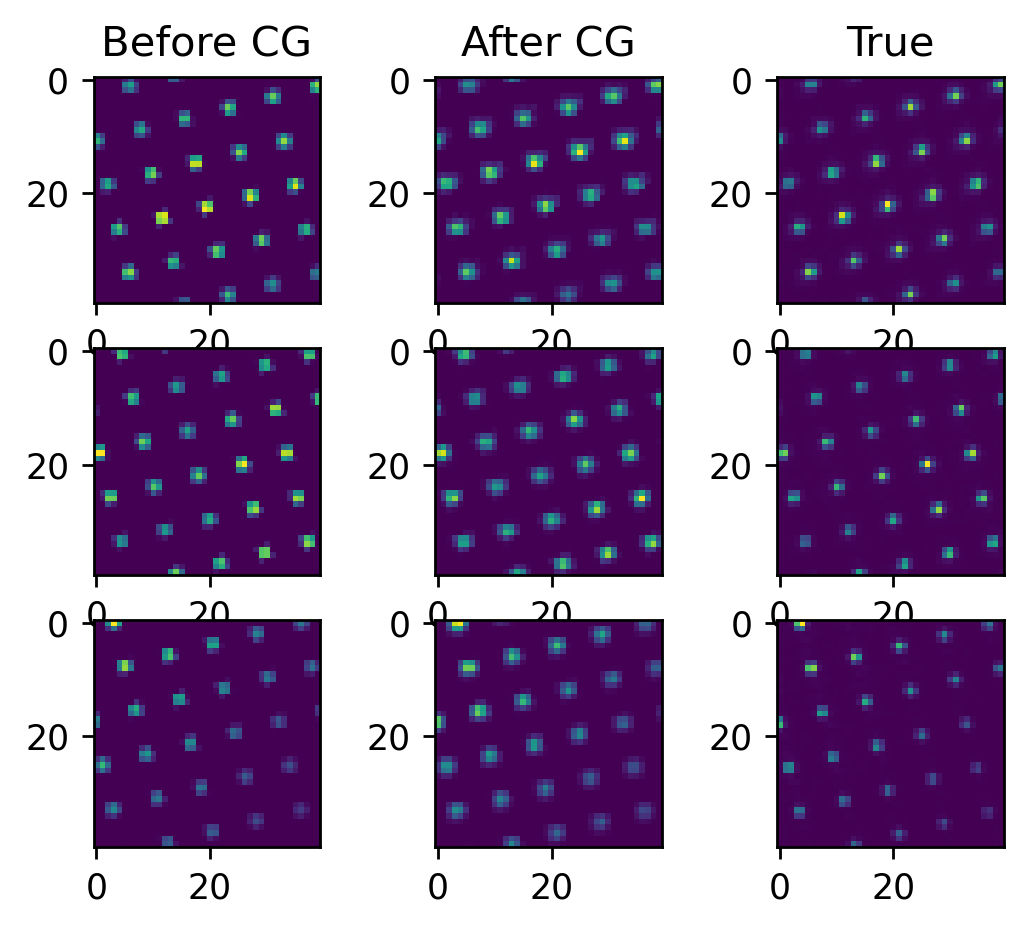

In [784]:
fig,ax = plt.subplots(3,3   ,figsize=(5,4),dpi=250)
ax[0,0].imshow(final_prediction.cpu()[0,wl,160:200,160:200]);ax[0,0].set_title('Before CG')
ax[0,1].imshow(yhat[0,0,160:200,160:200].detach().cpu());ax[0,1].set_title('After CG')
ax[0,2].imshow(mask_funda_wl[0,wl,160:200,160:200].detach().cpu());ax[0,2].set_title('True')
ax[1,0].imshow(final_prediction.cpu()[0,10,260:300,260:300])
ax[1,1].imshow(yhat[0,0,260:300,260:300].detach().cpu())
ax[1,2].imshow(mask_funda_wl[0,wl,260:300,260:300].detach().cpu())
ax[2,0].imshow(final_prediction.cpu()[0,wl,360:400,360:400])
ax[2,1].imshow(yhat[0,0,360:400,360:400].detach().cpu())
ax[2,2].imshow(mask_funda_wl[0,wl,360:400,360:400].detach().cpu())

Now can we correct for psf?

In [537]:
distortion_corrected = yhat.detach().clone()

In [585]:
batch_x = torch.zeros((1,distortion_corrected.shape[1],distortion_corrected.shape[2],distortion_corrected.shape[3])).to(device)
batch_y = torch.zeros((1,distortion_corrected.shape[1],distortion_corrected.shape[2],distortion_corrected.shape[3])).to(device)

for i in range(1):
    x = i//4
    y = i%4
    batch_x[i] = torch.roll(distortion_corrected[0],(x,y),(1,2))
    batch_y[i] = torch.roll(mask_funda_wl[0],(x,y),(1,2))



In [589]:
CG_channels = 6
kernelsize = 5

# initialiser = torch.rand((1,CG_channels,mask_nograting_funda.shape[2],mask_nograting_funda.shape[3]))
initialiser = torch.ones((1,CG_channels,mask_funda.shape[2],mask_funda.shape[3]))
initialiser = initialiser / CG_channels

CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_funda.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False, three_d=False).to(device) 

optimizer = torch.optim.Adam(CG_conv.parameters(), lr=1e-3)

init_reg_factor = 1e-5

In [590]:
start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()

    num_train_examples = 1

    optimizer.zero_grad()

    yhat = torch.concat([CG_conv(batch_x[:,i:i+1]) for i in range(final_prediction.shape[1])],dim=1)



    reg = hessian(CG_conv.CG.map,norm=1)


    mse = loss_fn(yhat,batch_y)
    loss =  mse  + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for n,parameter in enumerate(CG_conv.parameters()):
            # parameter.clamp_(min=0)
            if n!=2:
                # parameter.clamp_(min=0,max=1)
                parameter.clamp_(min=0)
            # else:
                # parameter.clamp_(max=1)

    train_loss         = loss.data.item()
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['tl'].append(train_loss)
    history2['mse'].append(mse.data.item())
    history2['reg'].append(init_reg_factor)
    history2['lr'].append(lr)

KeyboardInterrupt: 

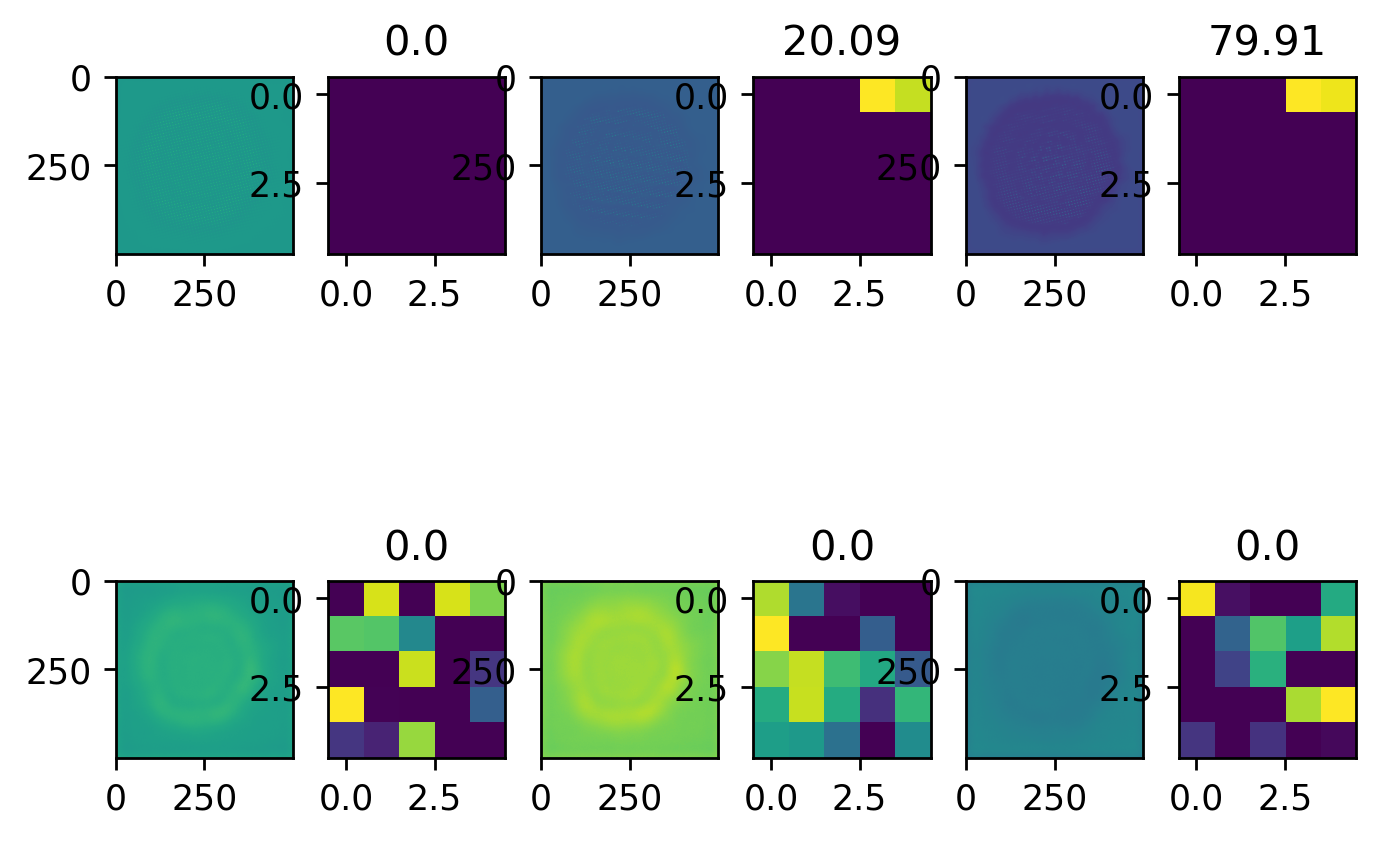

In [591]:
conv = [p for p in CG_conv.conv.parameters()][0]
maps,coeffs = [p for p in CG_conv.CG.parameters()][:2]


scaled_coeffs = coeffs[0,:,0,0] * conv.mean((1,2,3)) * maps.mean((0,2,3))

scaled_coeffs = scaled_coeffs / scaled_coeffs.sum()


plot_no = 2
fig,ax = plt.subplots(plot_no,6,dpi=250)

for i in range(plot_no):
    ax[i,0].imshow(maps.cpu().detach()[0,i*3])
    ax[i,1].imshow(conv.cpu().detach()[i*3,0]); ax[i,1].set_title(np.round(scaled_coeffs[i*3].detach().cpu().numpy()*100,2))
    ax[i,2].imshow(maps.cpu().detach()[0,i*3+1])
    ax[i,3].imshow(conv.cpu().detach()[i*3+1,0]); ax[i,3].set_title(np.round(scaled_coeffs[i*3+1].detach().cpu().numpy()*100,2))
    ax[i,4].imshow(maps.cpu().detach()[0,i*3+2])
    ax[i,5].imshow(conv.cpu().detach()[i*3+2,0]); ax[i,5].set_title(np.round(scaled_coeffs[i*3+2].detach().cpu().numpy()*100,2))